# Validation of surface temperature using data from the Lokalklimamonitoring

Check how well the temperature data from the remote sensing data correlates with temperature data measured from sensors of the Lokalklimamonitoring.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [94]:
from dark.dimension import dimensionalIterator
from datetime import datetime
import earthpy as ep
import earthpy.mask as em
import fiona
from glob import glob
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from osgeo import gdal
import pandas as pd
import rasterio
from rasterio.plot import show, show_hist
from shapely.geometry import shape, mapping
import subprocess
from osgeo import gdal
from osgeo.gdalconst import *
from osgeo import ogr
from osgeo import osr
from plotnine import *

import statsmodels.formula.api as smf


## Assemble the temperature data from the sensors and from the landsat data

### Deal with the sensor data

Read in all sensor temperature data

In [3]:
may = pd.read_csv('../../data/sensors/AWEL_Sensors_LoRa_202205.csv', sep = ';')
june = pd.read_csv('../../data/sensors/AWEL_Sensors_LoRa_202206.csv', sep = ';')
july = pd.read_csv('../../data/sensors/AWEL_Sensors_LoRa_202207.csv', sep = ';')
august = pd.read_csv('../../data/sensors/AWEL_Sensors_LoRa_202208.csv', sep = ';')
september = pd.read_csv('../../data/sensors/AWEL_Sensors_LoRa_202209.csv', sep = ';')

In [4]:
sensors = pd.concat([may, june, july, august, september])

In [5]:
# convert to datetime

sensors['starttime'] = pd.to_datetime(sensors['starttime'], format='%Y-%m-%d %H:%M')

In [6]:
locationSubset = sensors[['site', 'x', 'y']].drop_duplicates()

In [7]:
locationSubset.to_csv('sensor-locations.csv')

Check in QGIS which of those locations are outside the study area.

--> Don't use the following sensors:
 'Bülach - Feldermösli',
 'Bülach - Süd',
 'Elsau - Halden',
 'Lindau - Tagelswangen',
 'Oberembrach - Schüler',
 'Uster - Ackerstrasse',
 'Uster - Im-Lot',
 'Uster - Schulhaus-Dorf',
 'Uster - Schulhaus-Pünt',
 'Uster - Sunnenloobach',
 'Winterthur - Neumarkt',
 'Winterthur - Schulhaus-Altstadt',
 'Winterthur Bahnhof'

In [8]:
sensorsToDrop = [
    'Bülach - Feldermösli', 'Bülach - Süd', 'Elsau - Halden', 'Lindau - Tagelswangen', 'Oberembrach - Schüler',
    'Uster - Ackerstrasse', 'Uster - Im-Lot', 'Uster - Schulhaus-Dorf', 'Uster - Schulhaus-Pünt', 'Uster - Sunnenloobach',
    'Winterthur - Neumarkt', 'Winterthur - Schulhaus-Altstadt', 'Winterthur Bahnhof'
]

For each landsat scene figure out when it was taken --> look in the `*_MTL.txt` files.

In [9]:
def grep(pattern, filename):
    try:
        # Execute grep command
        result = subprocess.run(['grep', pattern, filename], capture_output=True, text=True, check=True)
        # Return the output
        return result.stdout
    except subprocess.CalledProcessError as e:
        # Handle error if grep command fails
        print("Grep command failed:", e)
        return None

In [10]:
# Figure out when the scenes were taken
files = sorted(glob('../../data/landsat/LC*/*_MTL.txt'), key = lambda x: int(x.split('_')[3]))

sceneTimes = {}

for file in files:
    date_ = grep("DATE_ACQUIRED", file).split(' = ')[-1]
    time_ = grep("SCENE_CENTER_TIME", file).split(' = ')[-1][1:-2]
    print(file.split('/')[-1], date_.strip(), time_)
    
    #sceneTimes[file] = datetime.strptime(f'{date_.strip()} 10:10:00', '%Y-%m-%d %H:%M:%S')
    sceneTimes[datetime.strptime(f'{date_.strip()} 10:10:00', '%Y-%m-%d %H:%M:%S')] = file

LC09_L2SP_194027_20220514_20230416_02_T1_MTL.txt 2022-05-14 10:09:55.9611790Z
LC09_L2SP_195027_20220521_20230416_02_T1_MTL.txt 2022-05-21 10:16:01.1851300Z
LC09_L2SP_194027_20220615_20230412_02_T1_MTL.txt 2022-06-15 10:09:57.0335010Z
LC08_L2SP_194027_20220623_20220705_02_T1_MTL.txt 2022-06-23 10:10:33.2592649Z
LC08_L2SP_195027_20220630_20220708_02_T1_MTL.txt 2022-06-30 10:16:45.1331590Z
LC09_L2SP_195027_20220708_20230408_02_T1_MTL.txt 2022-07-08 10:16:20.9828730Z
LC08_L2SP_194027_20220709_20220721_02_T1_MTL.txt 2022-07-09 10:10:33.9896950Z
LC08_L2SP_195027_20220716_20220726_02_T1_MTL.txt 2022-07-16 10:16:44.0343460Z
LC09_L2SP_194027_20220717_20230407_02_T1_MTL.txt 2022-07-17 10:10:10.3827649Z
LC09_L2SP_195027_20220724_20230406_02_T1_MTL.txt 2022-07-24 10:16:28.2840049Z
LC08_L2SP_194027_20220725_20220802_02_T1_MTL.txt 2022-07-25 10:10:40.8592750Z
LC08_L2SP_195027_20220801_20220806_02_T1_MTL.txt 2022-08-01 10:16:56.1474360Z
LC09_L2SP_194027_20220802_20230404_02_T1_MTL.txt 2022-08-02 10:1

--> Most of the scenes were taken at ~10.10. Therefore, look at the temperature at 10.10 on the day the scene was taken.

Subset the sensor data to the correct sensors and subset to the correct times.

In [11]:
sensorSubset = sensors.loc[~(sensors['site'].isin(sensorsToDrop))]

In [12]:
sensorSubset = sensorSubset.loc[sensorSubset['starttime'].isin(sceneTimes.keys())]

In [13]:
sensorSubset

starttime                            site  masl  magl  \
23046  2022-05-14 10:10:00             Opfikon - Glattpark   426   2.0   
23959  2022-05-21 10:10:00             Opfikon - Glattpark   426   2.0   
27193  2022-05-14 10:10:00       Regensdorf - Bahnhof-Nord   440   2.0   
28194  2022-05-21 10:10:00       Regensdorf - Bahnhof-Nord   440   2.0   
31528  2022-05-14 10:10:00  Regensdorf - Geerenwiesstrasse   439   2.0   
...                    ...                             ...   ...   ...   
123559 2022-09-18 10:10:00       Zürich - Sihlfeld-Kapelle   414   2.0   
123707 2022-09-18 10:10:00            Zürich - Vulkanplatz   398   2.0   
123849 2022-09-18 10:10:00          Zürich - Werdinsel-neu   399   2.0   
123989 2022-09-18 10:10:00                Zürich - Witikon   604   2.0   
124137 2022-09-18 10:10:00               Zürich - Zürihorn   408   2.0   

              x        y  sensor  temperature  humidity  
23046   2684807  1253174    2681        21.32     53.51  
23959   2684807  1253174    2681        20.80     48.84  
27193   2678019  1254725    2685        21.29     53.31  
28194   2678019  1254725    2685        21.38     48.53  
31528   2678262  1254941    2654        22.98     58.07  
...         ...      ...     ...          ...       ...  
123559  2680785  1247588    2810        13.68     62.44  
123707  2679386  1249607    2695        13.56     57.95  
123849  2679316  1250429     530        15.61     60.53  
123989  2687035  1245950    2653        12.41     61.93  
124137  2684037  1245349    2679        13.61     67.28  

[618 rows x 9 columns]

### Read out the temperature values from the landsat data

In [14]:
def getRasterValue(filename, x, y):
    """
    Get temperature data at a specific location.
    """
    # Register all of the drivers
    gdal.AllRegister()
    # Open the image
    ds = gdal.Open(filename, GA_ReadOnly)
    
    # Get georeference info
    transform = ds.GetGeoTransform()
    xOrigin = transform[0]
    yOrigin = transform[3]
    pixelWidth = transform[1]
    pixelHeight = transform[5]
    
    # Compute pixel offset
    xOffset = int((x - xOrigin) / pixelWidth)
    yOffset = int((y - yOrigin) / pixelHeight)

    # Read temperature data 
    band = ds.GetRasterBand(1) # 1-based index
    data = band.ReadAsArray(xOffset, yOffset, 1, 1)
    value = data[0,0]
    return value

In [15]:
satelliteTemp = []

for i, row in sensorSubset.iterrows():
    base = sceneTimes[row['starttime']].split('/')[4]
    filename = f'../../data/landsat/resolution/{base}_ST_B10-resolution.TIF'
    sT = getRasterValue(filename, row['x'], row['y'])
    satelliteTemp.append(sT)

sensorSubset['satelliteTemp'] = satelliteTemp

/Users/barbara/opt/anaconda3/envs/310gis/lib/python3.10/site-packages/osgeo/gdal.py:312: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.


In [16]:
sensorSubset = sensorSubset.loc[sensorSubset.satelliteTemp != -999.0]

In [17]:
sensorSubset['strtime'] = sensorSubset['starttime'].apply(lambda row: datetime.strftime(row, '%Y-%m-%d'))

/var/folders/z3/x6qjmllx6314vnr7cktm58680000gn/T/ipykernel_10277/2745670712.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [18]:
sensorSubset

starttime                            site  masl  magl  \
23046  2022-05-14 10:10:00             Opfikon - Glattpark   426   2.0   
27193  2022-05-14 10:10:00       Regensdorf - Bahnhof-Nord   440   2.0   
31528  2022-05-14 10:10:00  Regensdorf - Geerenwiesstrasse   439   2.0   
35746  2022-05-14 10:10:00      Schlieren - Badenerstrasse   394   2.0   
40047  2022-05-14 10:10:00            Schlieren - Brachweg   391   2.0   
...                    ...                             ...   ...   ...   
122091 2022-09-18 10:10:00        Zürich - offene Rennbahn   430   2.0   
122384 2022-09-18 10:10:00              Zürich - Perron-HB   407   2.0   
122677 2022-09-18 10:10:00        Zürich - Schimmelstrasse   413   4.0   
123414 2022-09-18 10:10:00               Zürich - Sihlfeld   412   2.0   
124137 2022-09-18 10:10:00               Zürich - Zürihorn   408   2.0   

              x        y  sensor  temperature  humidity  satelliteTemp  \
23046   2684807  1253174    2681        21.32     53.51      28.536371   
27193   2678019  1254725    2685        21.29     53.31      36.185900   
31528   2678262  1254941    2654        22.98     58.07      30.761502   
35746   2676170  1250196    2650        22.66     50.60      34.148760   
40047   2676474  1251042    2658        21.26     64.16      32.135546   
...         ...      ...     ...          ...       ...            ...   
122091  2684027  1251619    2683        14.40     58.55      18.938571   
122384  2682716  1248218    2689        13.97     57.89      20.302361   
122677  2681942  1247245     536        15.29     53.71      21.218391   
123414  2680558  1247730     537        15.11     59.49      14.307154   
124137  2684037  1245349    2679        13.61     67.28      15.359904   

           strtime  
23046   2022-05-14  
27193   2022-05-14  
31528   2022-05-14  
35746   2022-05-14  
40047   2022-05-14  
...            ...  
122091  2022-09-18  
122384  2022-09-18  
122677  2022-09-18  
123414  2022-09-18  
124137  2022-09-18  

[450 rows x 11 columns]

### Take a look at the average temperatures per day

In [19]:
averages = sensorSubset.groupby('starttime')[['temperature', 'satelliteTemp']].mean().reset_index()

In [20]:
averages

starttime  temperature  satelliteTemp
0  2022-05-14 10:10:00    21.764828      31.901825
1  2022-06-15 10:10:00    27.410000      36.580516
2  2022-06-23 10:10:00    26.347714      38.235540
3  2022-06-30 10:10:00    27.322667      29.988118
4  2022-07-08 10:10:00    20.775652      32.799534
5  2022-07-16 10:10:00    25.263235      37.531695
6  2022-07-17 10:10:00    26.422000      38.703516
7  2022-07-24 10:10:00    27.726957      39.922985
8  2022-07-25 10:10:00    31.324857      41.791160
9  2022-08-01 10:10:00    27.712059      35.748595
10 2022-08-02 10:10:00    25.740571      36.482682
11 2022-08-09 10:10:00    25.737059      34.155496
12 2022-08-10 10:10:00    25.029429      36.949095
13 2022-08-26 10:10:00    26.263333      21.649061
14 2022-09-02 10:10:00    20.770294      28.960105
15 2022-09-18 10:10:00    13.977333      17.721528

In [21]:
averages['strtime'] = averages['starttime'].apply(lambda row: datetime.strftime(row, '%Y-%m-%d'))

In [22]:
averages['furtherUse'] = ['no', 'no', 'yes', 'no', 'no', 'yes', 'yes', 'no', 'yes', 'yes', 'yes', 'yes', 'yes', 'no', 'no', 'no']

In [23]:
averages

starttime  temperature  satelliteTemp     strtime furtherUse
0  2022-05-14 10:10:00    21.764828      31.901825  2022-05-14         no
1  2022-06-15 10:10:00    27.410000      36.580516  2022-06-15         no
2  2022-06-23 10:10:00    26.347714      38.235540  2022-06-23        yes
3  2022-06-30 10:10:00    27.322667      29.988118  2022-06-30         no
4  2022-07-08 10:10:00    20.775652      32.799534  2022-07-08         no
5  2022-07-16 10:10:00    25.263235      37.531695  2022-07-16        yes
6  2022-07-17 10:10:00    26.422000      38.703516  2022-07-17        yes
7  2022-07-24 10:10:00    27.726957      39.922985  2022-07-24         no
8  2022-07-25 10:10:00    31.324857      41.791160  2022-07-25        yes
9  2022-08-01 10:10:00    27.712059      35.748595  2022-08-01        yes
10 2022-08-02 10:10:00    25.740571      36.482682  2022-08-02        yes
11 2022-08-09 10:10:00    25.737059      34.155496  2022-08-09        yes
12 2022-08-10 10:10:00    25.029429      36.949095  2022-08-10        yes
13 2022-08-26 10:10:00    26.263333      21.649061  2022-08-26         no
14 2022-09-02 10:10:00    20.770294      28.960105  2022-09-02         no
15 2022-09-18 10:10:00    13.977333      17.721528  2022-09-18         no

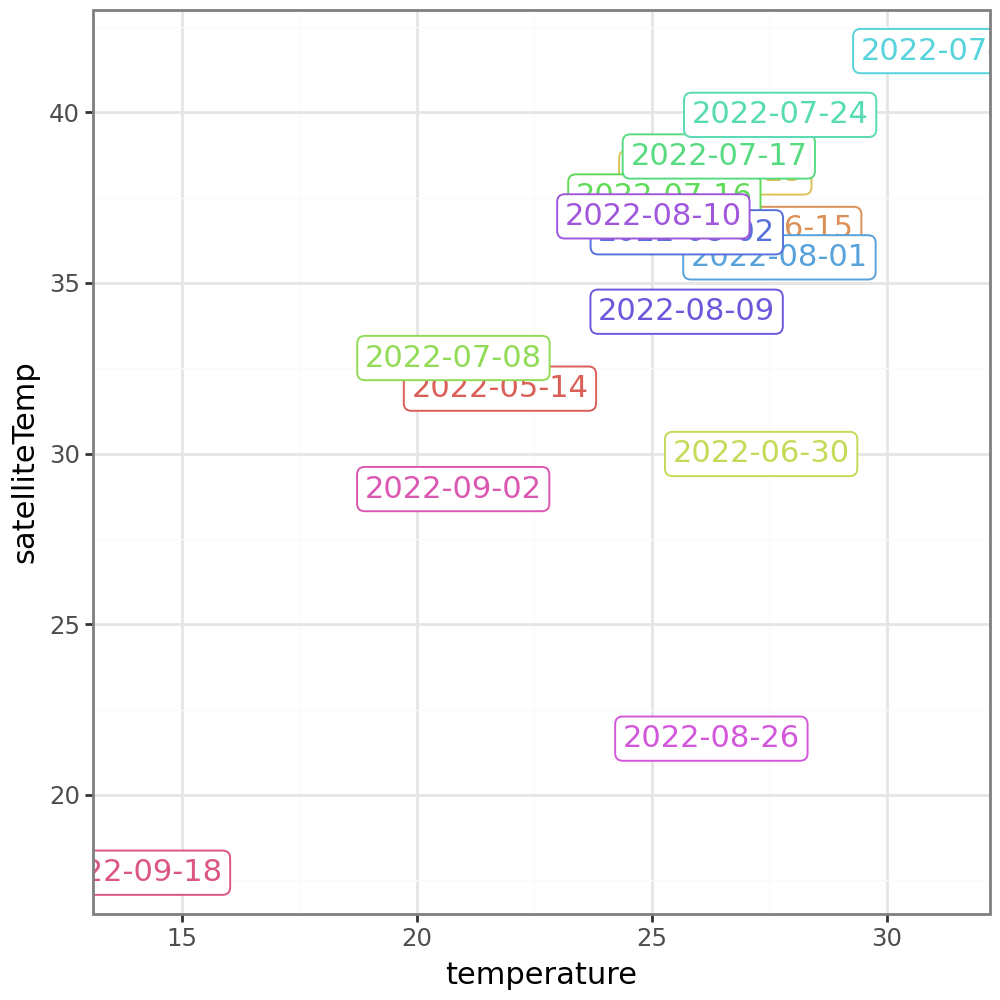

In [24]:
gp = (
    ggplot(averages)
    + aes(x="temperature", y="satelliteTemp", color='strtime', label = 'strtime')
    + geom_point(size=5)
    + theme_bw()
    + theme(figure_size=(5, 5))
    + geom_label()
    + guides(color='none')
)

gp

--> on average, `2022-06-30` and `2022-08-26` are out.

### Plot the average temperatures over time

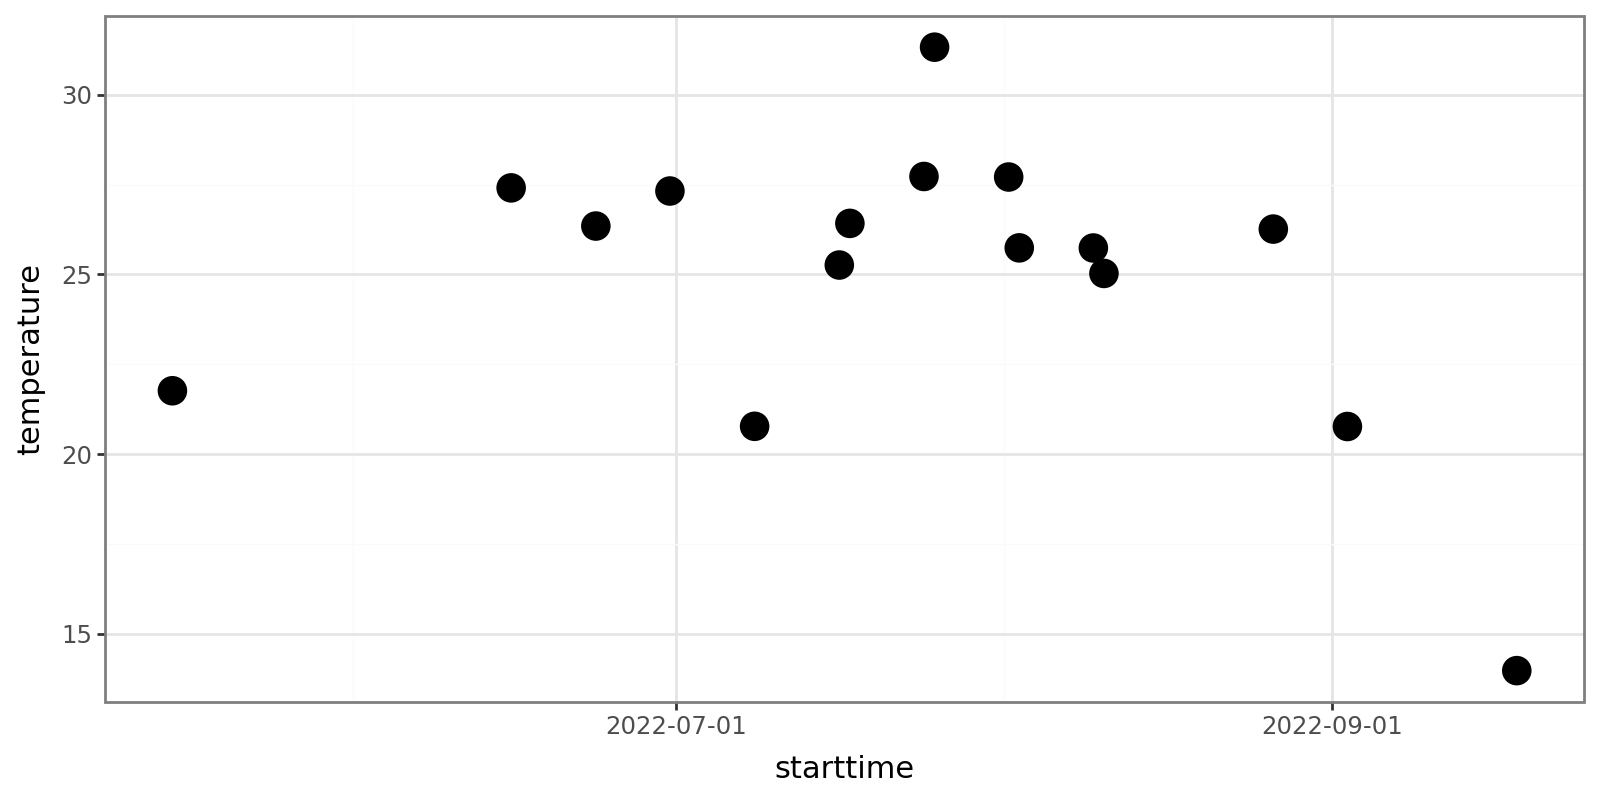

In [25]:
gp = (
    ggplot(averages)
    + aes(x="starttime", y="temperature")
    + geom_point(size=5)
    + theme_bw()
    + theme(figure_size=(8, 4))
)

gp

## Scatterplots of satellite temperatures and sensor temperatures

/Users/barbara/opt/anaconda3/envs/310gis/lib/python3.10/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 1 rows containing missing values.


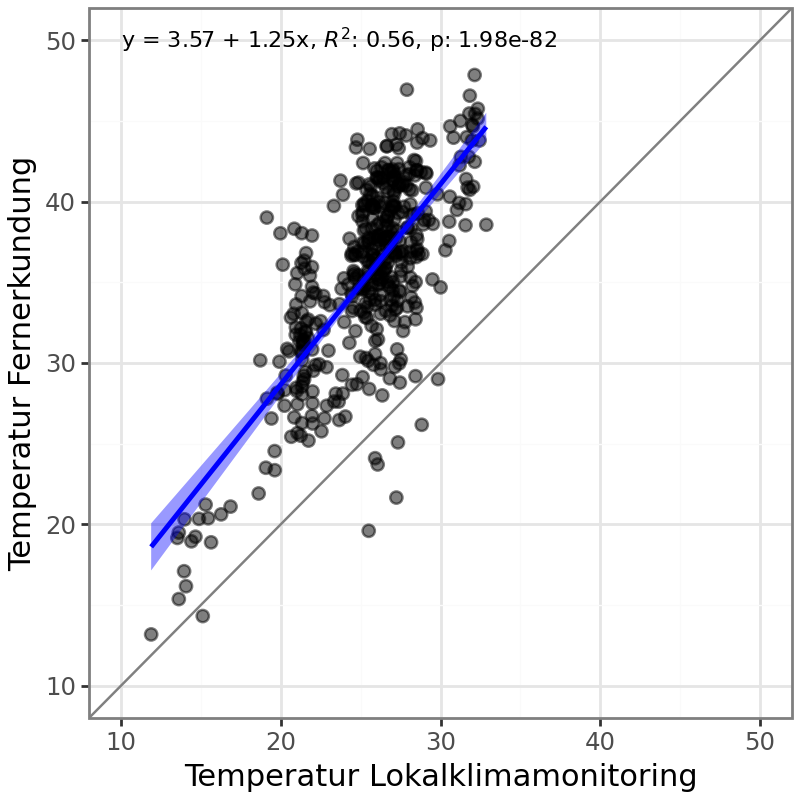

In [132]:
gp = (
    ggplot(sensorSubset)
    + aes(x="temperature", y="satelliteTemp")
    + geom_point(alpha=0.5, size=2)
    + theme_bw()
    + theme(figure_size=(4, 4))
    + geom_smooth(method = 'lm', se = True, color='blue', fill='blue')
    + geom_abline(intercept=0, slope=1, color='grey')
    + xlim(10, 50)
    + ylim(10, 50)
    + labs(
        x="Temperatur Lokalklimamonitoring",
        y="Temperatur Fernerkundung"  
    )
)

# Calculate regression parameters
fit = smf.ols('satelliteTemp ~ temperature', data=sensorSubset).fit()
equation = f'y = {fit.params["Intercept"]:.2f} + {fit.params["temperature"]:.2f}x'
r_squared = f'$R^2$: {fit.rsquared:.2f}'
p_value = f'p: {fit.f_pvalue:.2e}'

# Add annotation with regression equation, R-squared, and p-value
gp = (
    gp
    + annotate(
        "text",
        x=10,
        y=50,
        label=f"{equation}, {r_squared}, {p_value}",
        size=8,
        color="black",
        ha='left'
    )
)

gp

/Users/barbara/opt/anaconda3/envs/310gis/lib/python3.10/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 1 rows containing missing values.


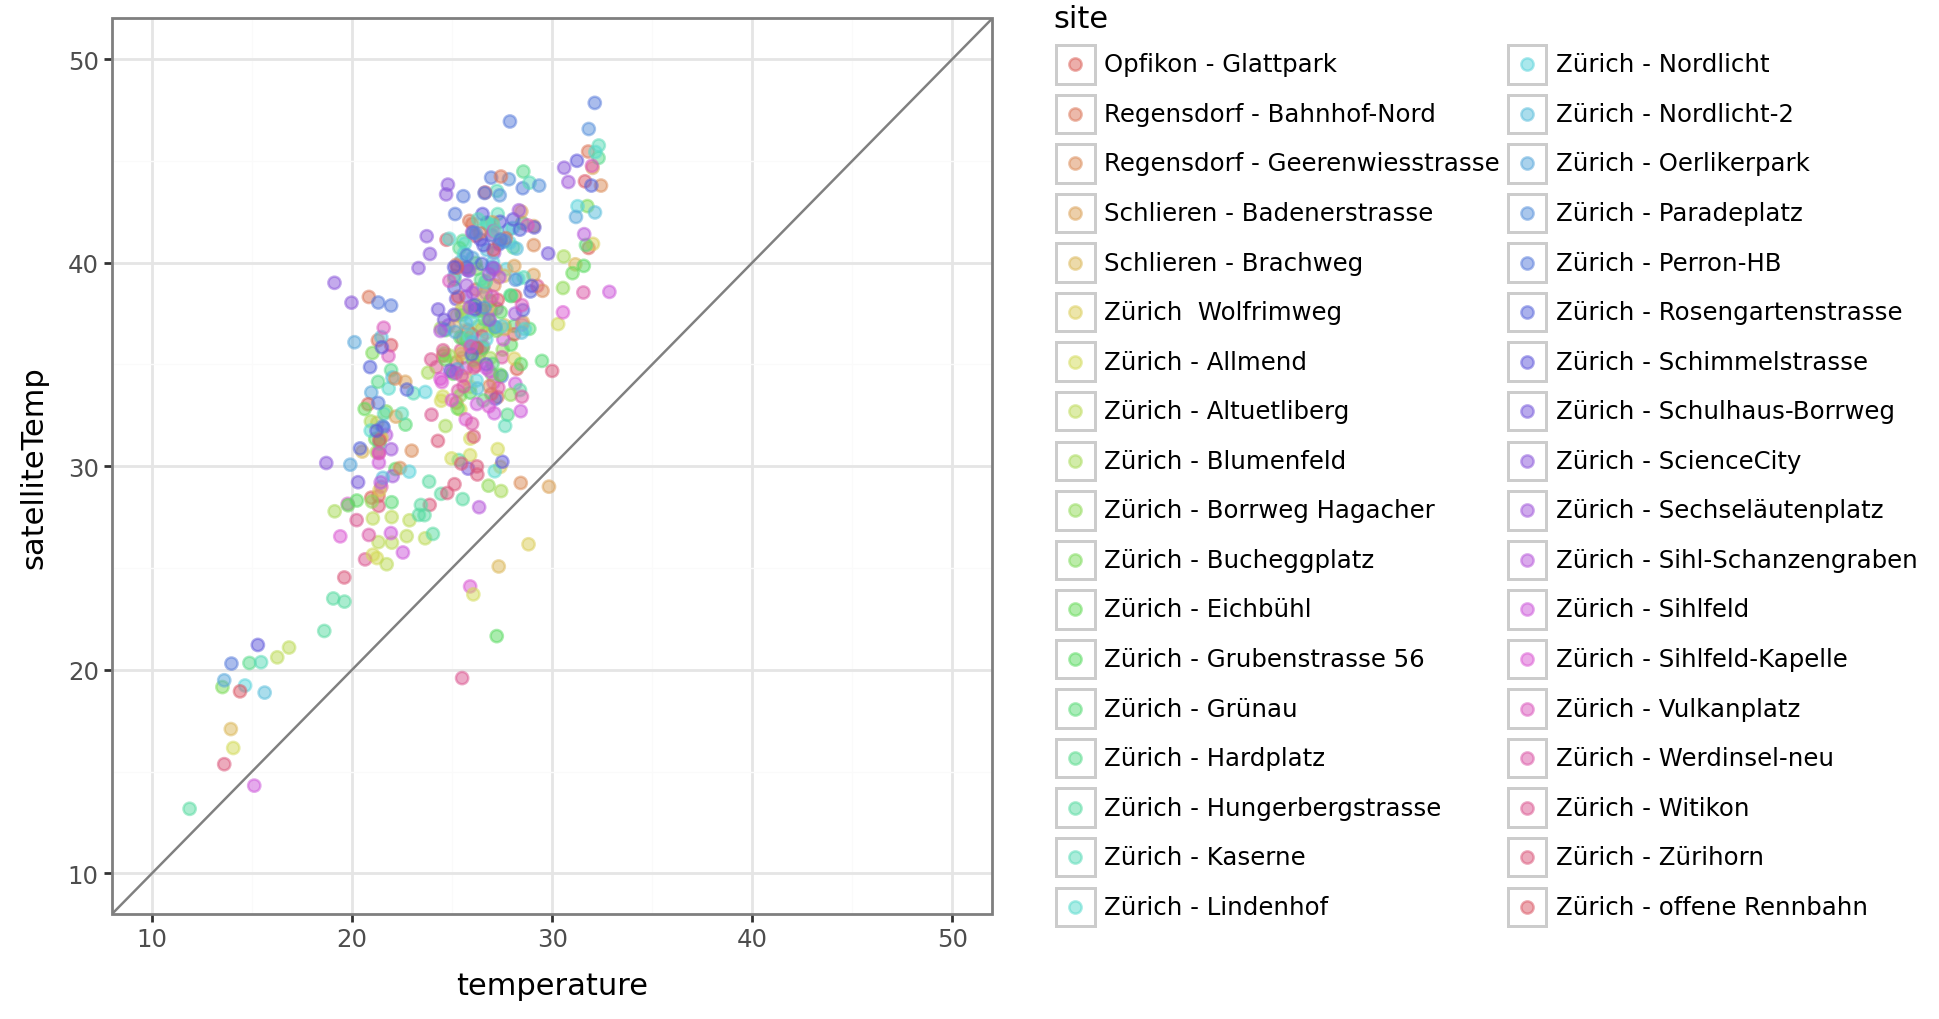

In [40]:
# Titers split and coloured by exposures
gp = (
    ggplot(sensorSubset)
    + aes(x="temperature", y="satelliteTemp", color='site')
    + geom_point(alpha=0.5, size=2)
    + theme_bw()
    + theme(figure_size=(9.7, 5.1))
    + geom_abline(intercept=0, slope=1, color='grey')
    + xlim(10, 50)
    + ylim(10, 50)
)

gp

/Users/barbara/opt/anaconda3/envs/310gis/lib/python3.10/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 1 rows containing missing values.


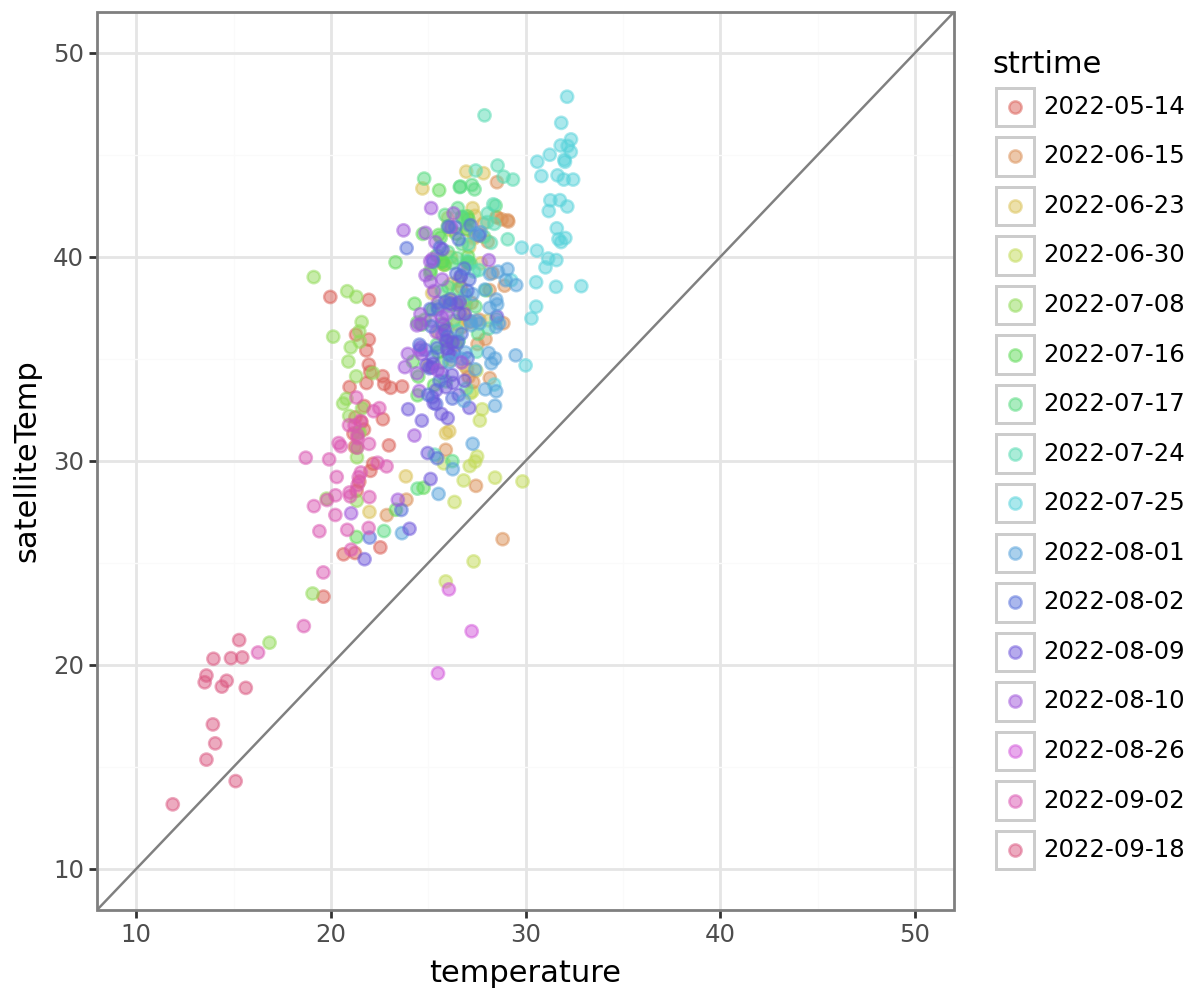

In [41]:
# Titers split and coloured by exposures
gp = (
    ggplot(sensorSubset)
    + aes(x="temperature", y="satelliteTemp", color='strtime')
    + geom_point(alpha=0.5, size=2)
    + theme_bw()
    + theme(figure_size=(6, 5))
    + geom_abline(intercept=0, slope=1, color='grey')
    + xlim(10, 50)
    + ylim(10, 50)
)

gp

/Users/barbara/opt/anaconda3/envs/310gis/lib/python3.10/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 1 rows containing missing values.


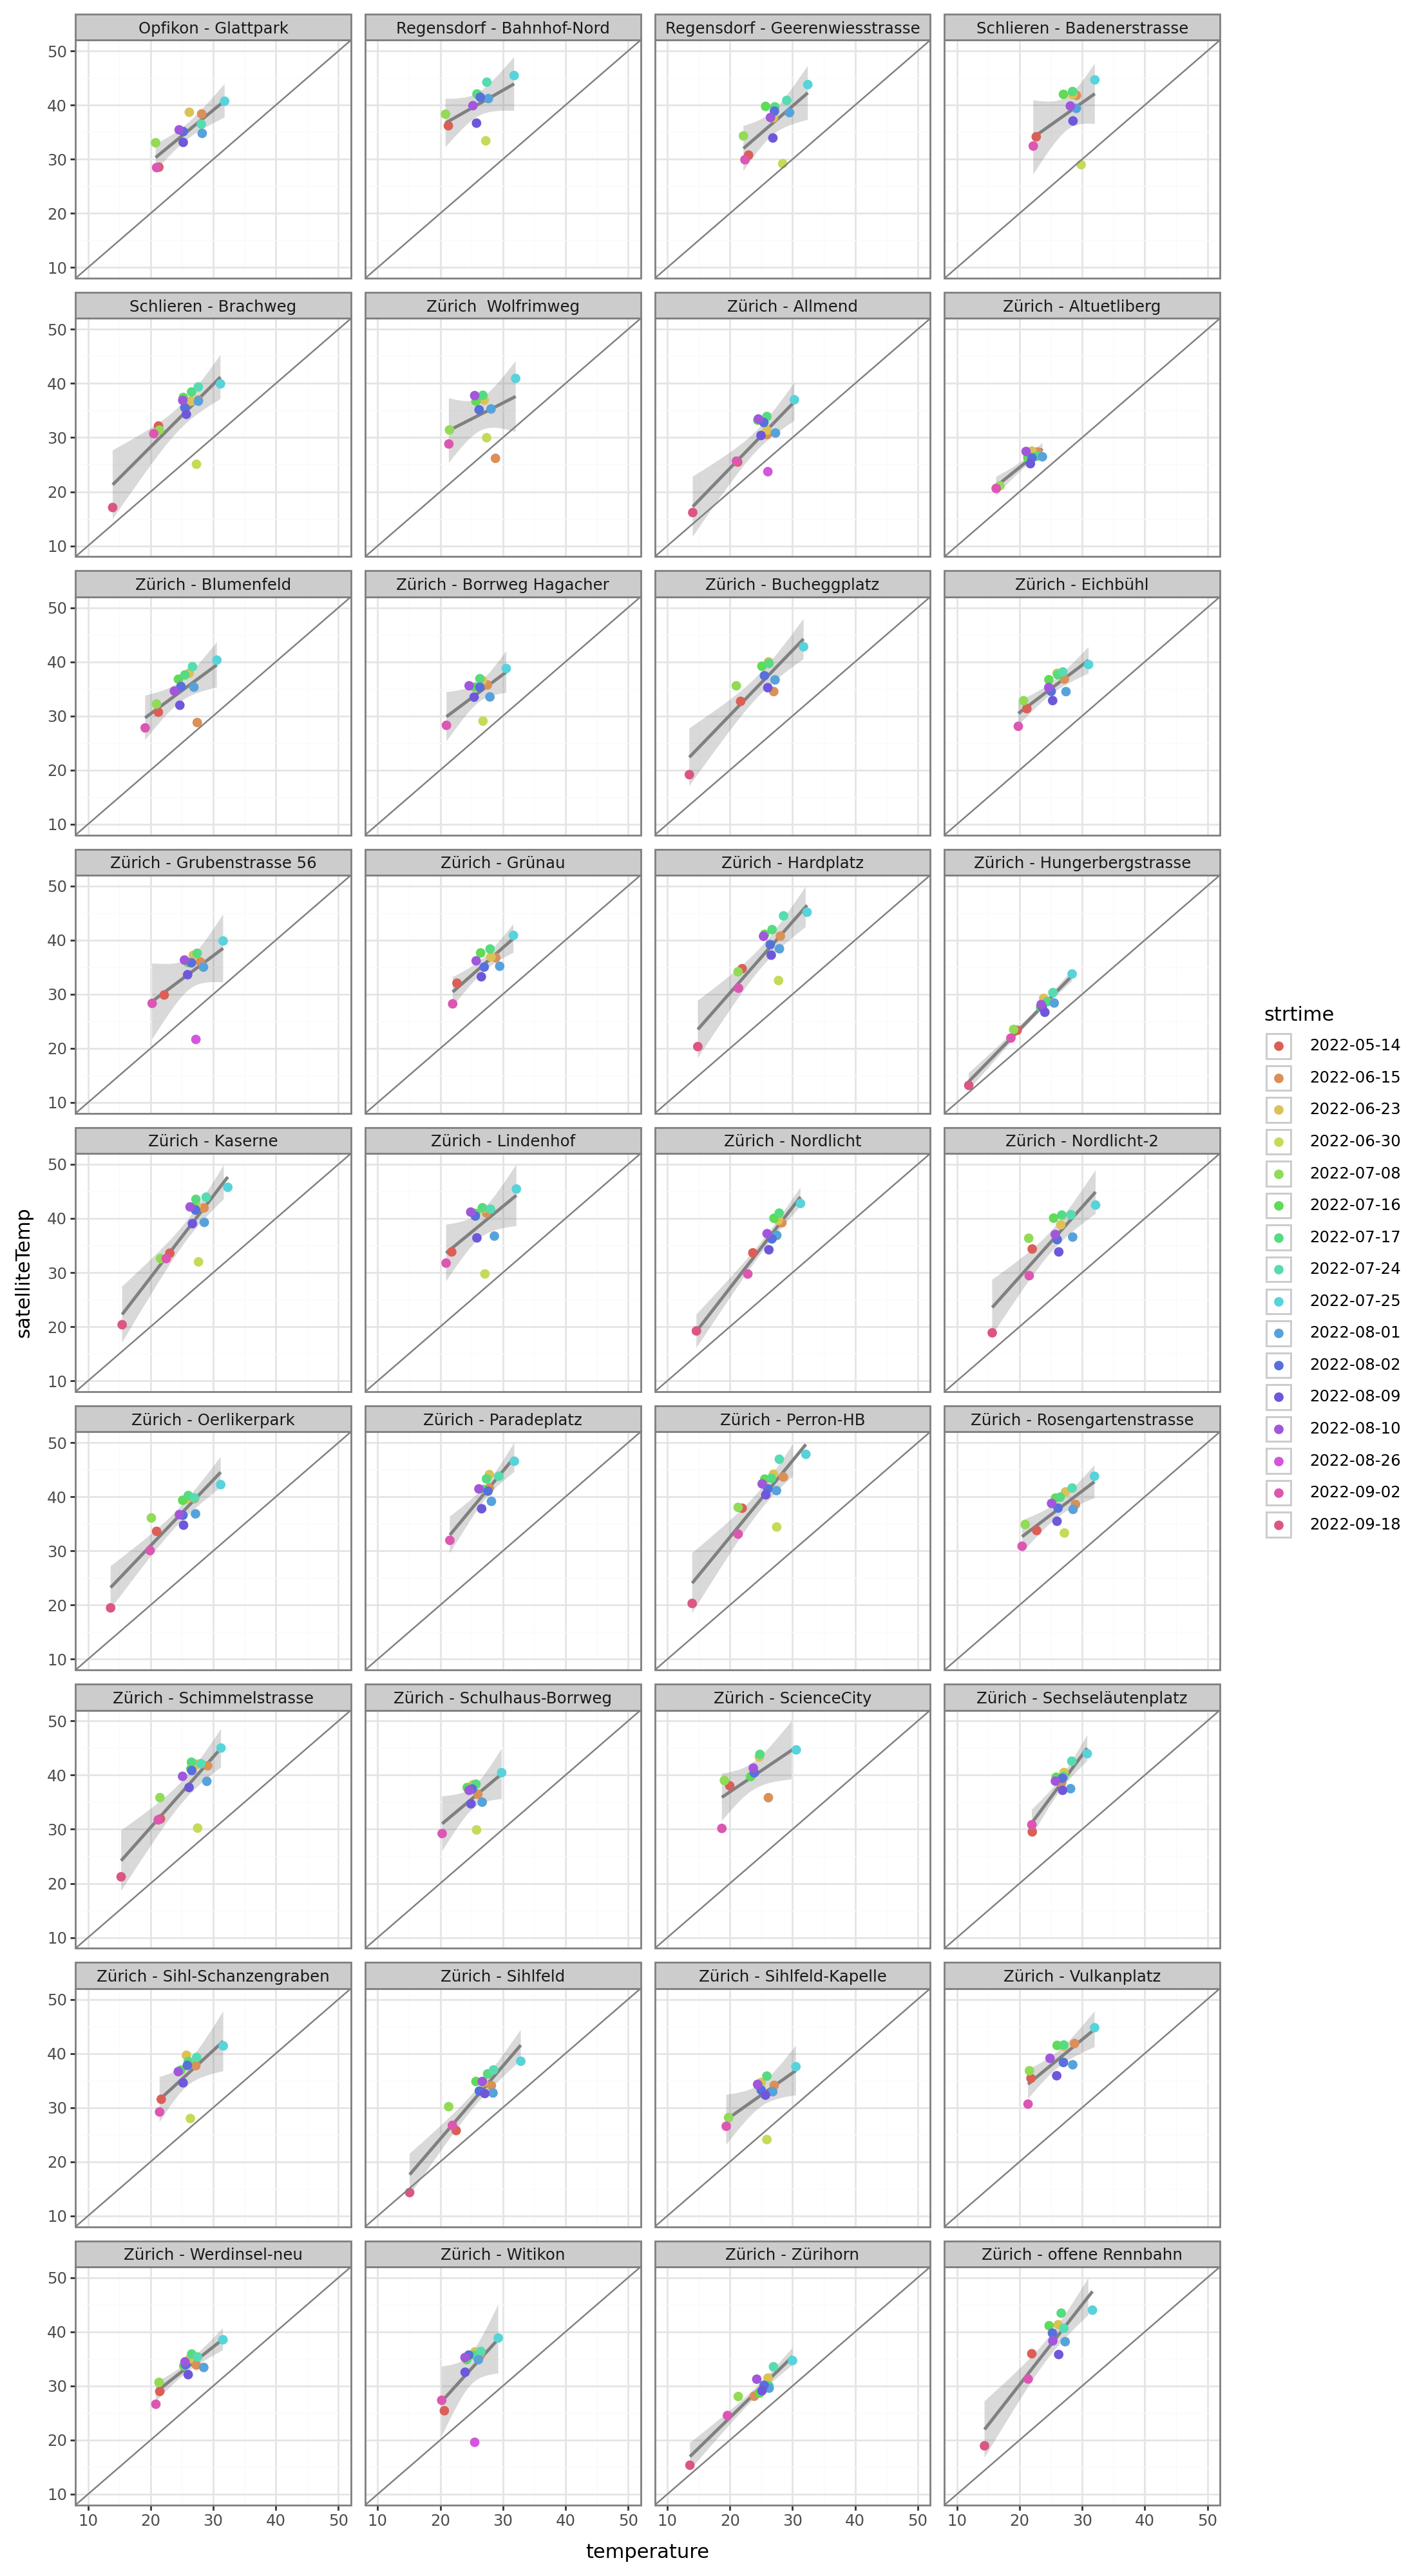

In [52]:
# Titers split and coloured by exposures
gp = (
    ggplot(sensorSubset)
    + aes(x="temperature", y="satelliteTemp", color='strtime')
    + geom_smooth(method = 'lm', se = True, color='grey', fill='grey', alpha=0.3)
    + geom_point(alpha=1, size=2)
    + theme_bw()
    + theme(figure_size=(11, 20))
    + geom_abline(intercept=0, slope=1, color='grey')
    + facet_wrap("site", ncol=4)
    + xlim(10, 50)
    + ylim(10, 50)
)

gp

In [149]:
# Perform linear regression for each facet
regression_results = []
for site, data in sensorSubset.groupby('site'):
    fit = smf.ols('satelliteTemp ~ temperature', data=data).fit()
    equation = f'y = {fit.params["Intercept"]:.2f} + {fit.params["temperature"]:.2f}x'
    r_squared = f'$R^2$: {fit.rsquared:.2f}'
    p_value = f'p: {fit.f_pvalue:.2e}'
    regression_results.append([site, f"{equation}, {r_squared}, {p_value}"])

regressionResultsDf = pd.DataFrame(regression_results, columns=['site', 'equation'])

# Merge regression results with data for each facet
sensorSubset_merged = pd.merge(sensorSubset, regressionResultsDf, on='site')

/Users/barbara/opt/anaconda3/envs/310gis/lib/python3.10/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 1 rows containing missing values.


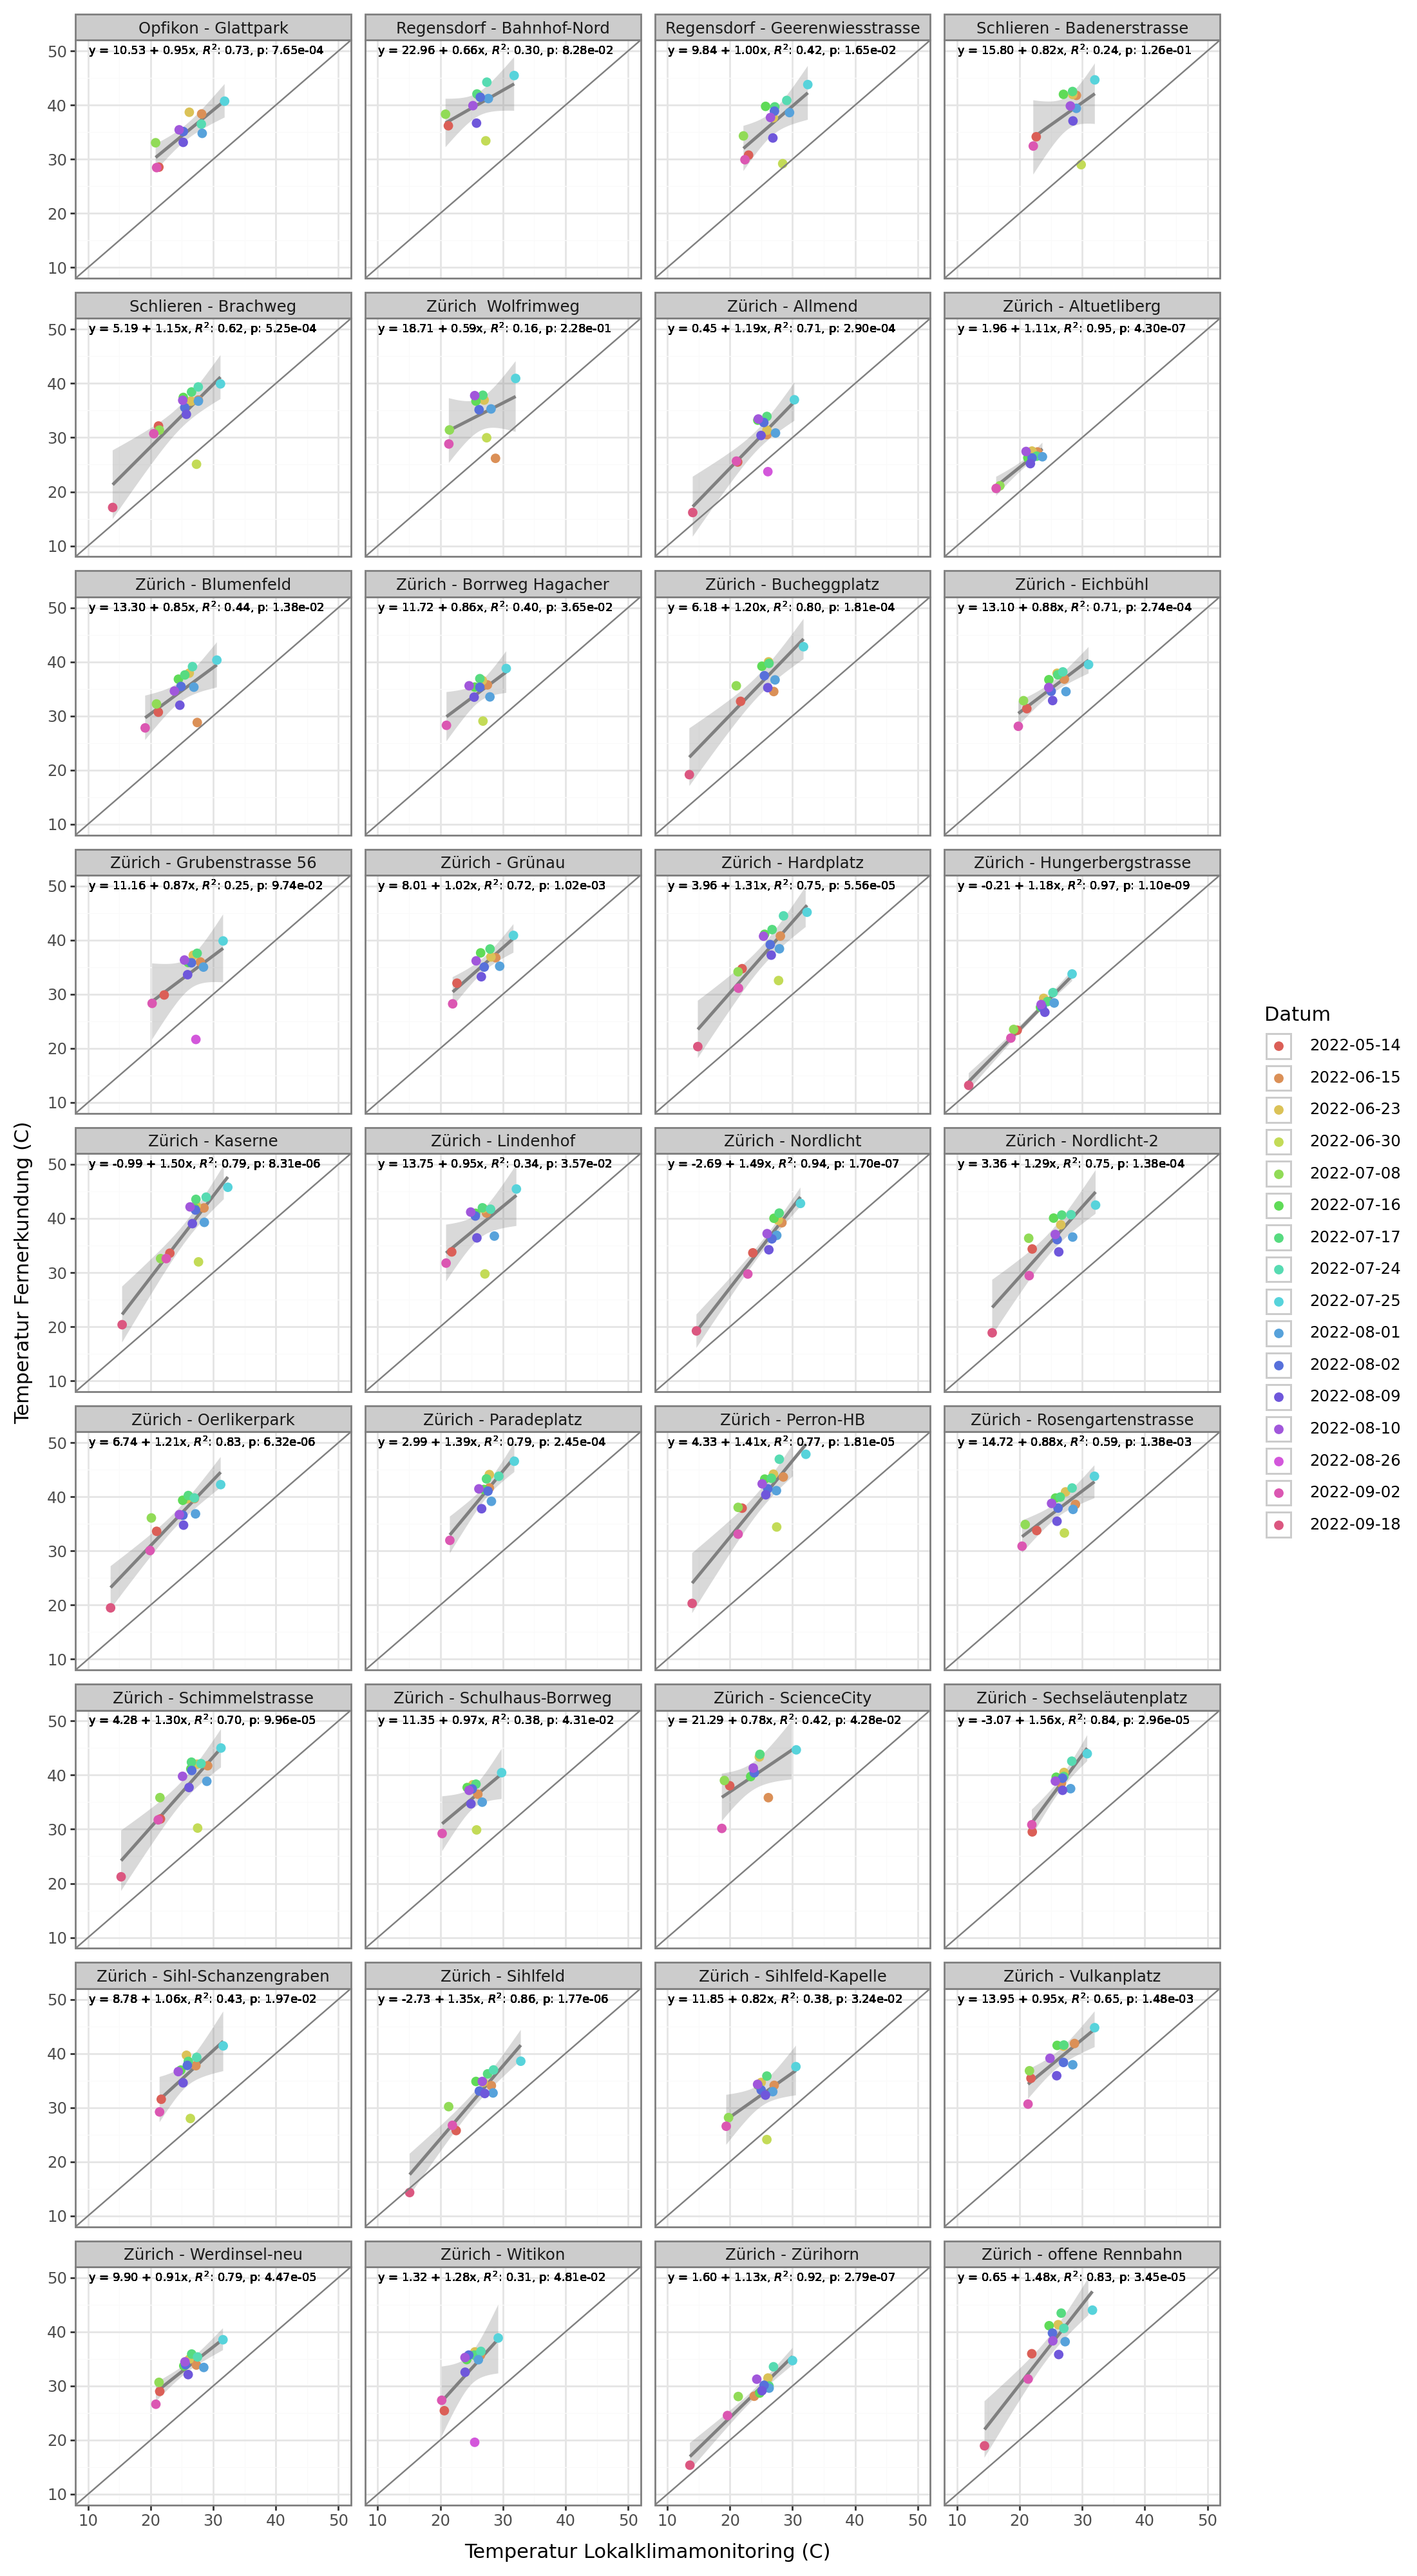

In [153]:
# Create the plot
gp = (
    ggplot(sensorSubset_merged)
    + aes(x="temperature", y="satelliteTemp", color='strtime', label='equation')
    + geom_smooth(method='lm', se=True, color='grey', fill='grey', alpha=0.3)
    + geom_point(alpha=1, size=2)
    + theme_bw()
    + theme(figure_size=(11, 20))
    + geom_abline(intercept=0, slope=1, color='grey')
    + facet_wrap("site", ncol=4)
    + xlim(10, 50)
    + ylim(10, 50)
    + labs(
        x="Temperatur Lokalklimamonitoring (C)",
        y="Temperatur Fernerkundung (C)",
        color='Datum',
    )
    + geom_text(
        x=10,
        y=50,
        size=6.5,
        color="black",
        ha='left'
    )
)

gp

In [154]:
gp.save('by-site.pdf')

/Users/barbara/opt/anaconda3/envs/310gis/lib/python3.10/site-packages/plotnine/ggplot.py:604: PlotnineWarning: Saving 11 x 20 in image.
/Users/barbara/opt/anaconda3/envs/310gis/lib/python3.10/site-packages/plotnine/ggplot.py:605: PlotnineWarning: Filename: by-site.pdf
/Users/barbara/opt/anaconda3/envs/310gis/lib/python3.10/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 1 rows containing missing values.


/Users/barbara/opt/anaconda3/envs/310gis/lib/python3.10/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 1 rows containing missing values.


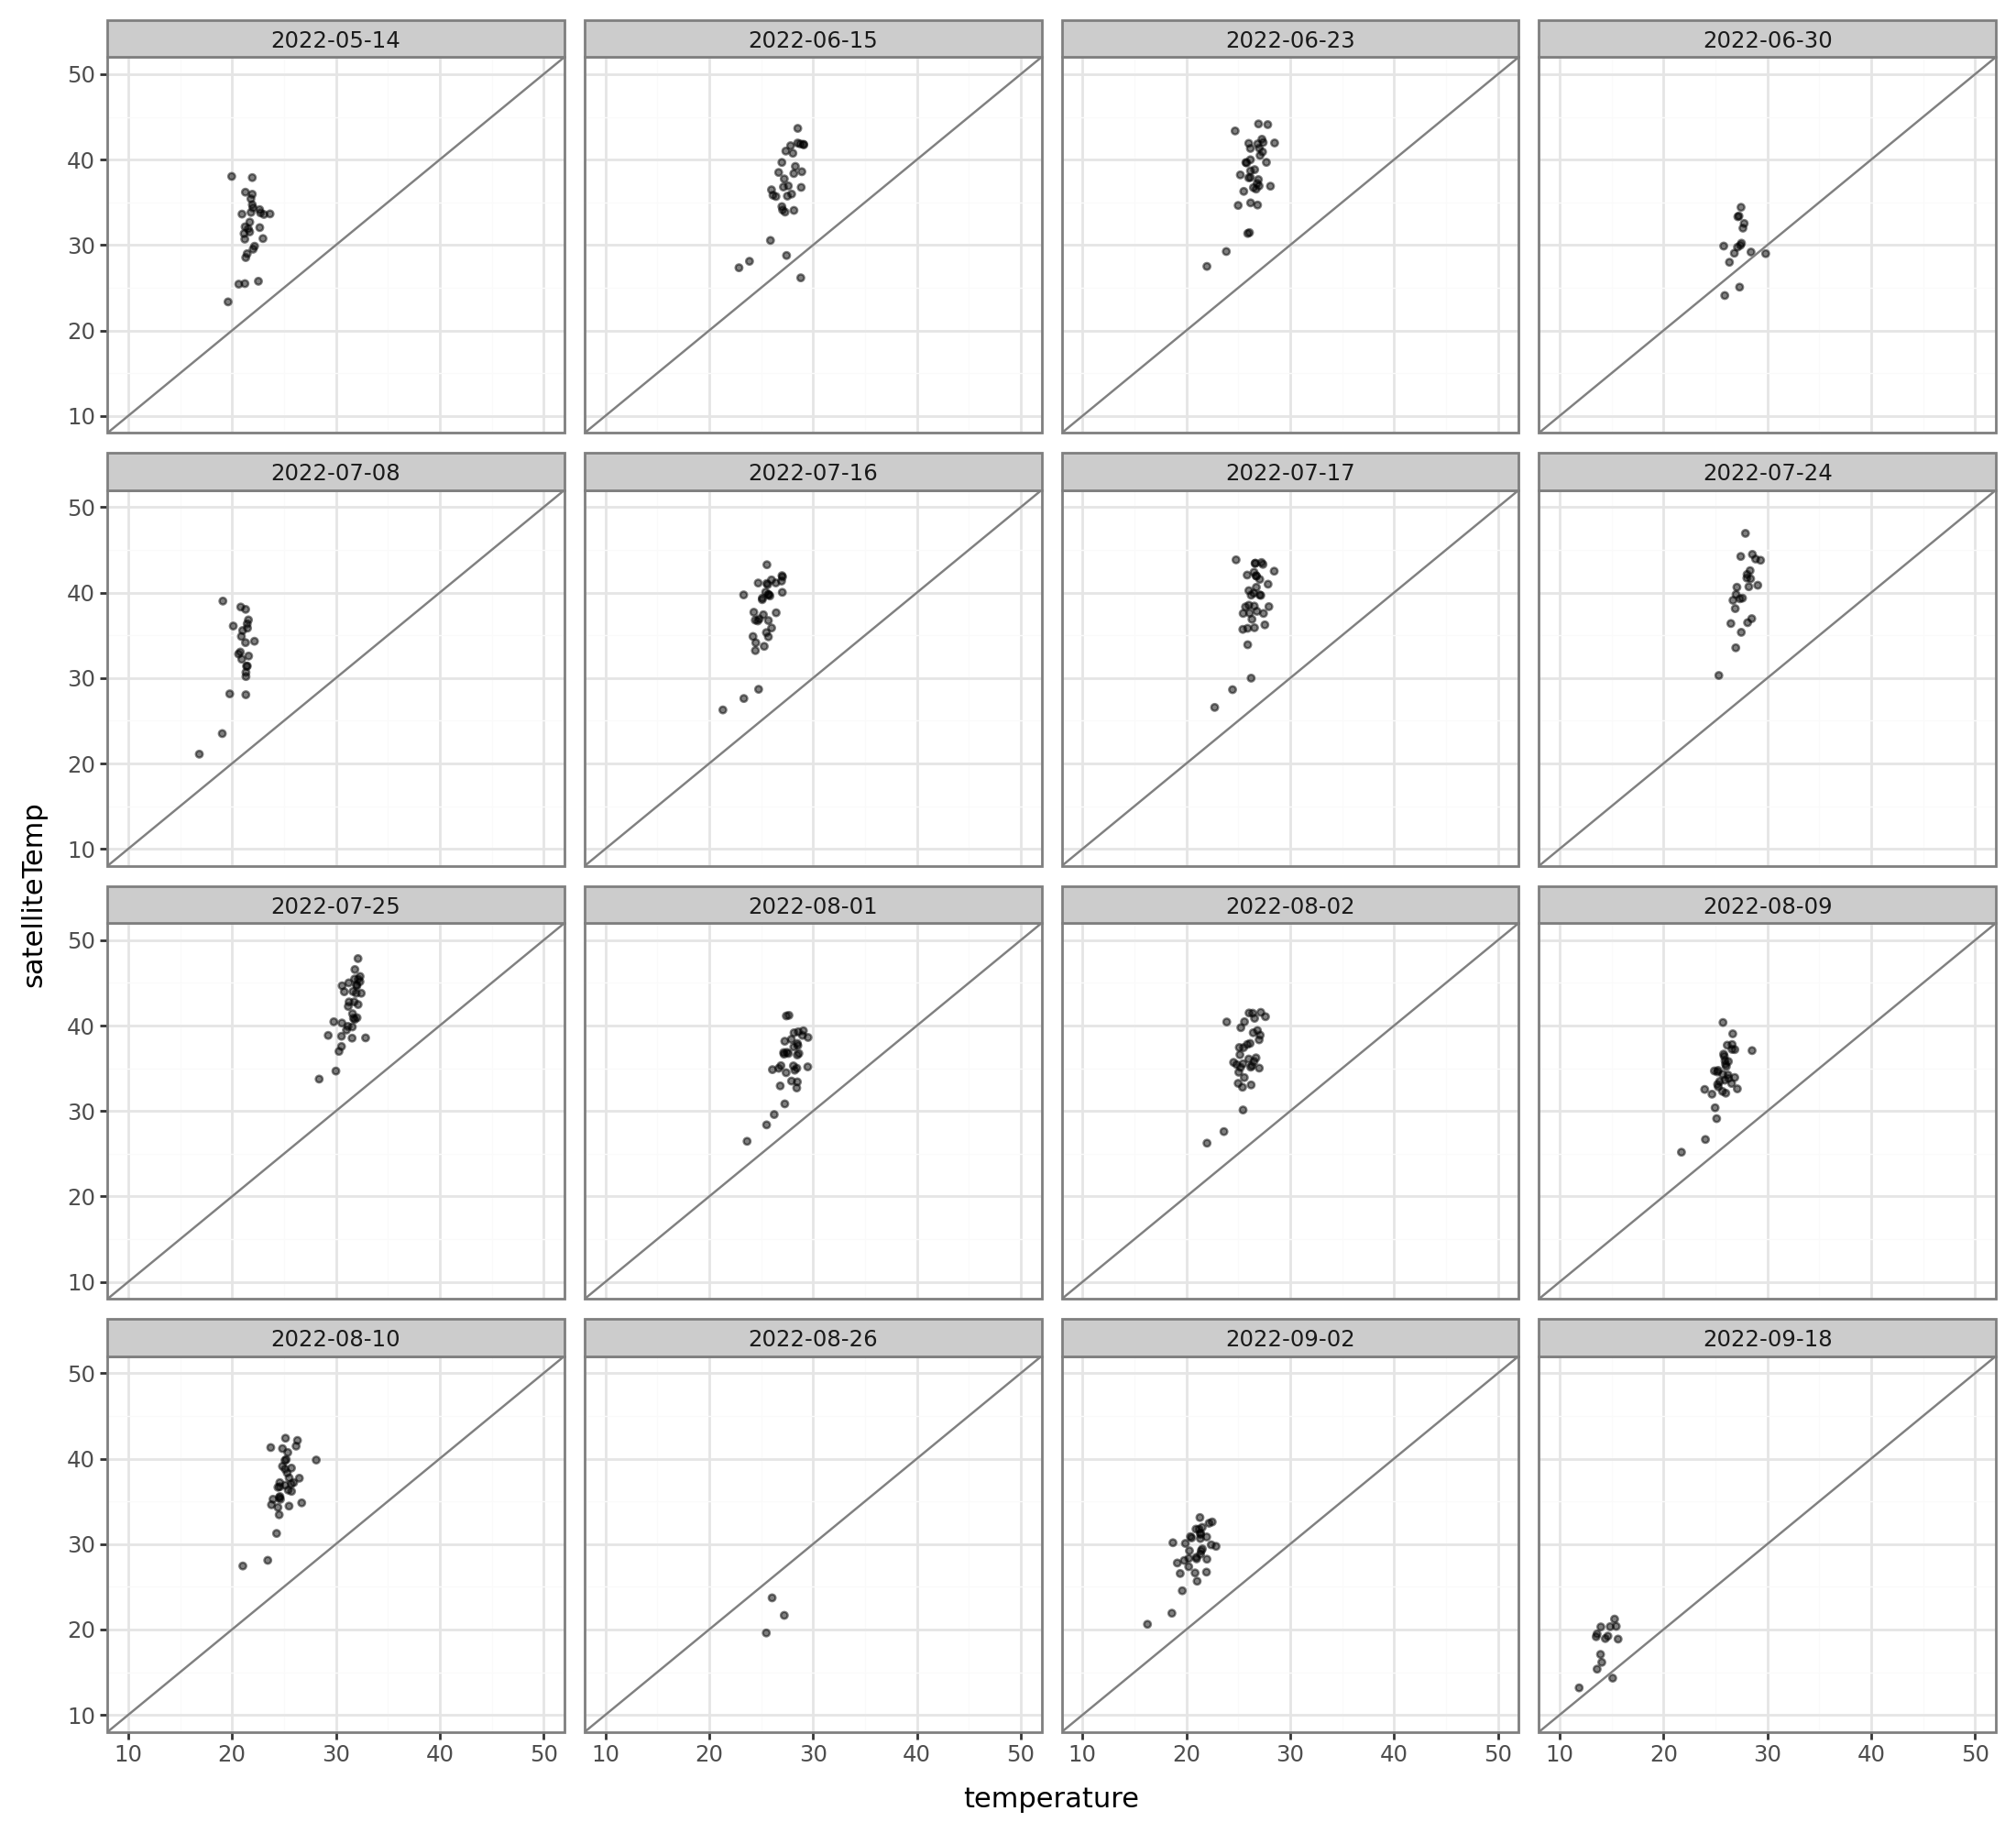

In [54]:
# Titers split and coloured by exposures
gp = (
    ggplot(sensorSubset)
    + aes(x="temperature", y="satelliteTemp")
    + geom_point(alpha=0.5, size=1)
    + theme_bw()
    + theme(figure_size=(11, 10))
    + geom_abline(intercept=0, slope=1, color='grey')
    + facet_wrap("strtime", ncol=4)
    + xlim(10, 50)
    + ylim(10, 50)
)

gp

/Users/barbara/opt/anaconda3/envs/310gis/lib/python3.10/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 1 rows containing missing values.


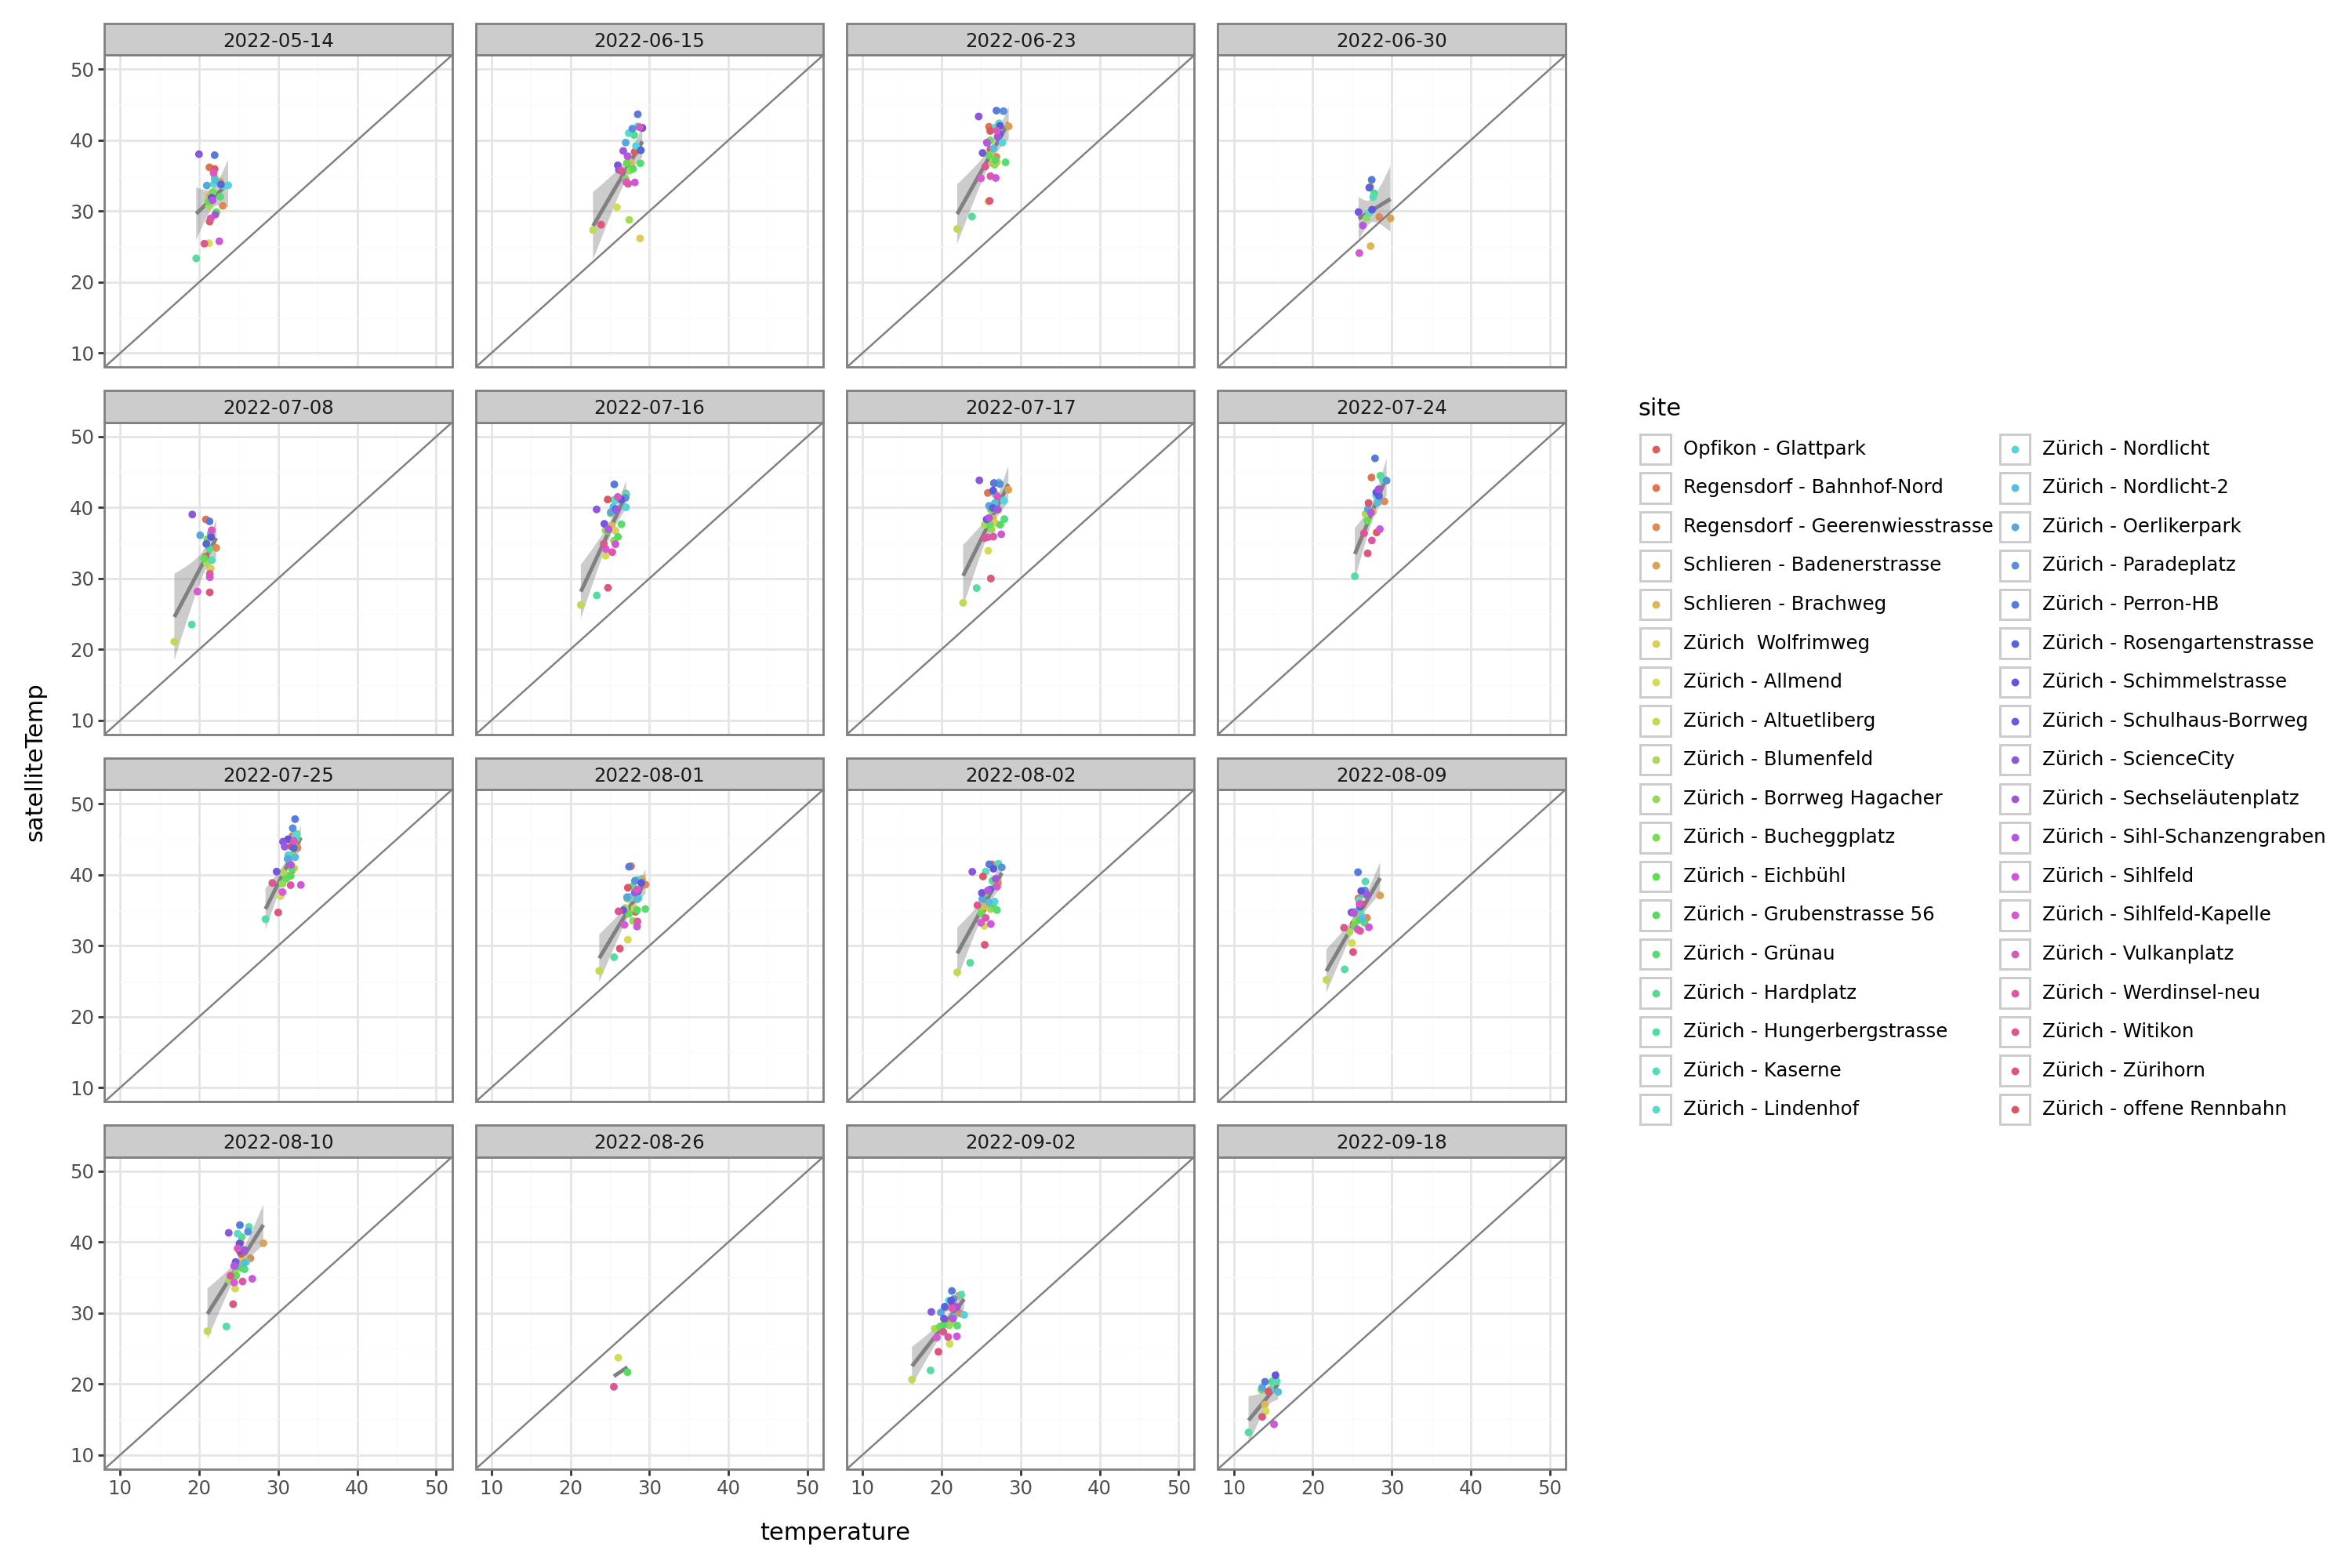

In [57]:
# Titers split and coloured by exposures
gp = (
    ggplot(sensorSubset)
    + aes(x="temperature", y="satelliteTemp", color="site")
    + geom_smooth(method = 'lm', se = True, color='grey', fill='grey')
    + geom_point(alpha=1, size=1)
    + theme_bw()
    + theme(figure_size=(15, 10))
    + geom_abline(intercept=0, slope=1, color='grey')
    + facet_wrap("strtime", ncol=4)
    + xlim(10, 50)
    + ylim(10, 50)
)

gp

In [155]:
# Perform linear regression for each facet
regression_results = []
for date, data in sensorSubset.groupby('strtime'):
    fit = smf.ols('satelliteTemp ~ temperature', data=data).fit()
    equation = f'y = {fit.params["Intercept"]:.2f} + {fit.params["temperature"]:.2f}x'
    r_squared = f'$R^2$: {fit.rsquared:.2f}'
    p_value = f'p: {fit.f_pvalue:.2e}'
    regression_results.append([date, f"{equation}, {r_squared}, {p_value}"])

regressionResultsDf = pd.DataFrame(regression_results, columns=['strtime', 'equation'])

# Merge regression results with data for each facet
sensorSubset_merged = pd.merge(sensorSubset, regressionResultsDf, on='strtime')

/Users/barbara/opt/anaconda3/envs/310gis/lib/python3.10/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 1 rows containing missing values.


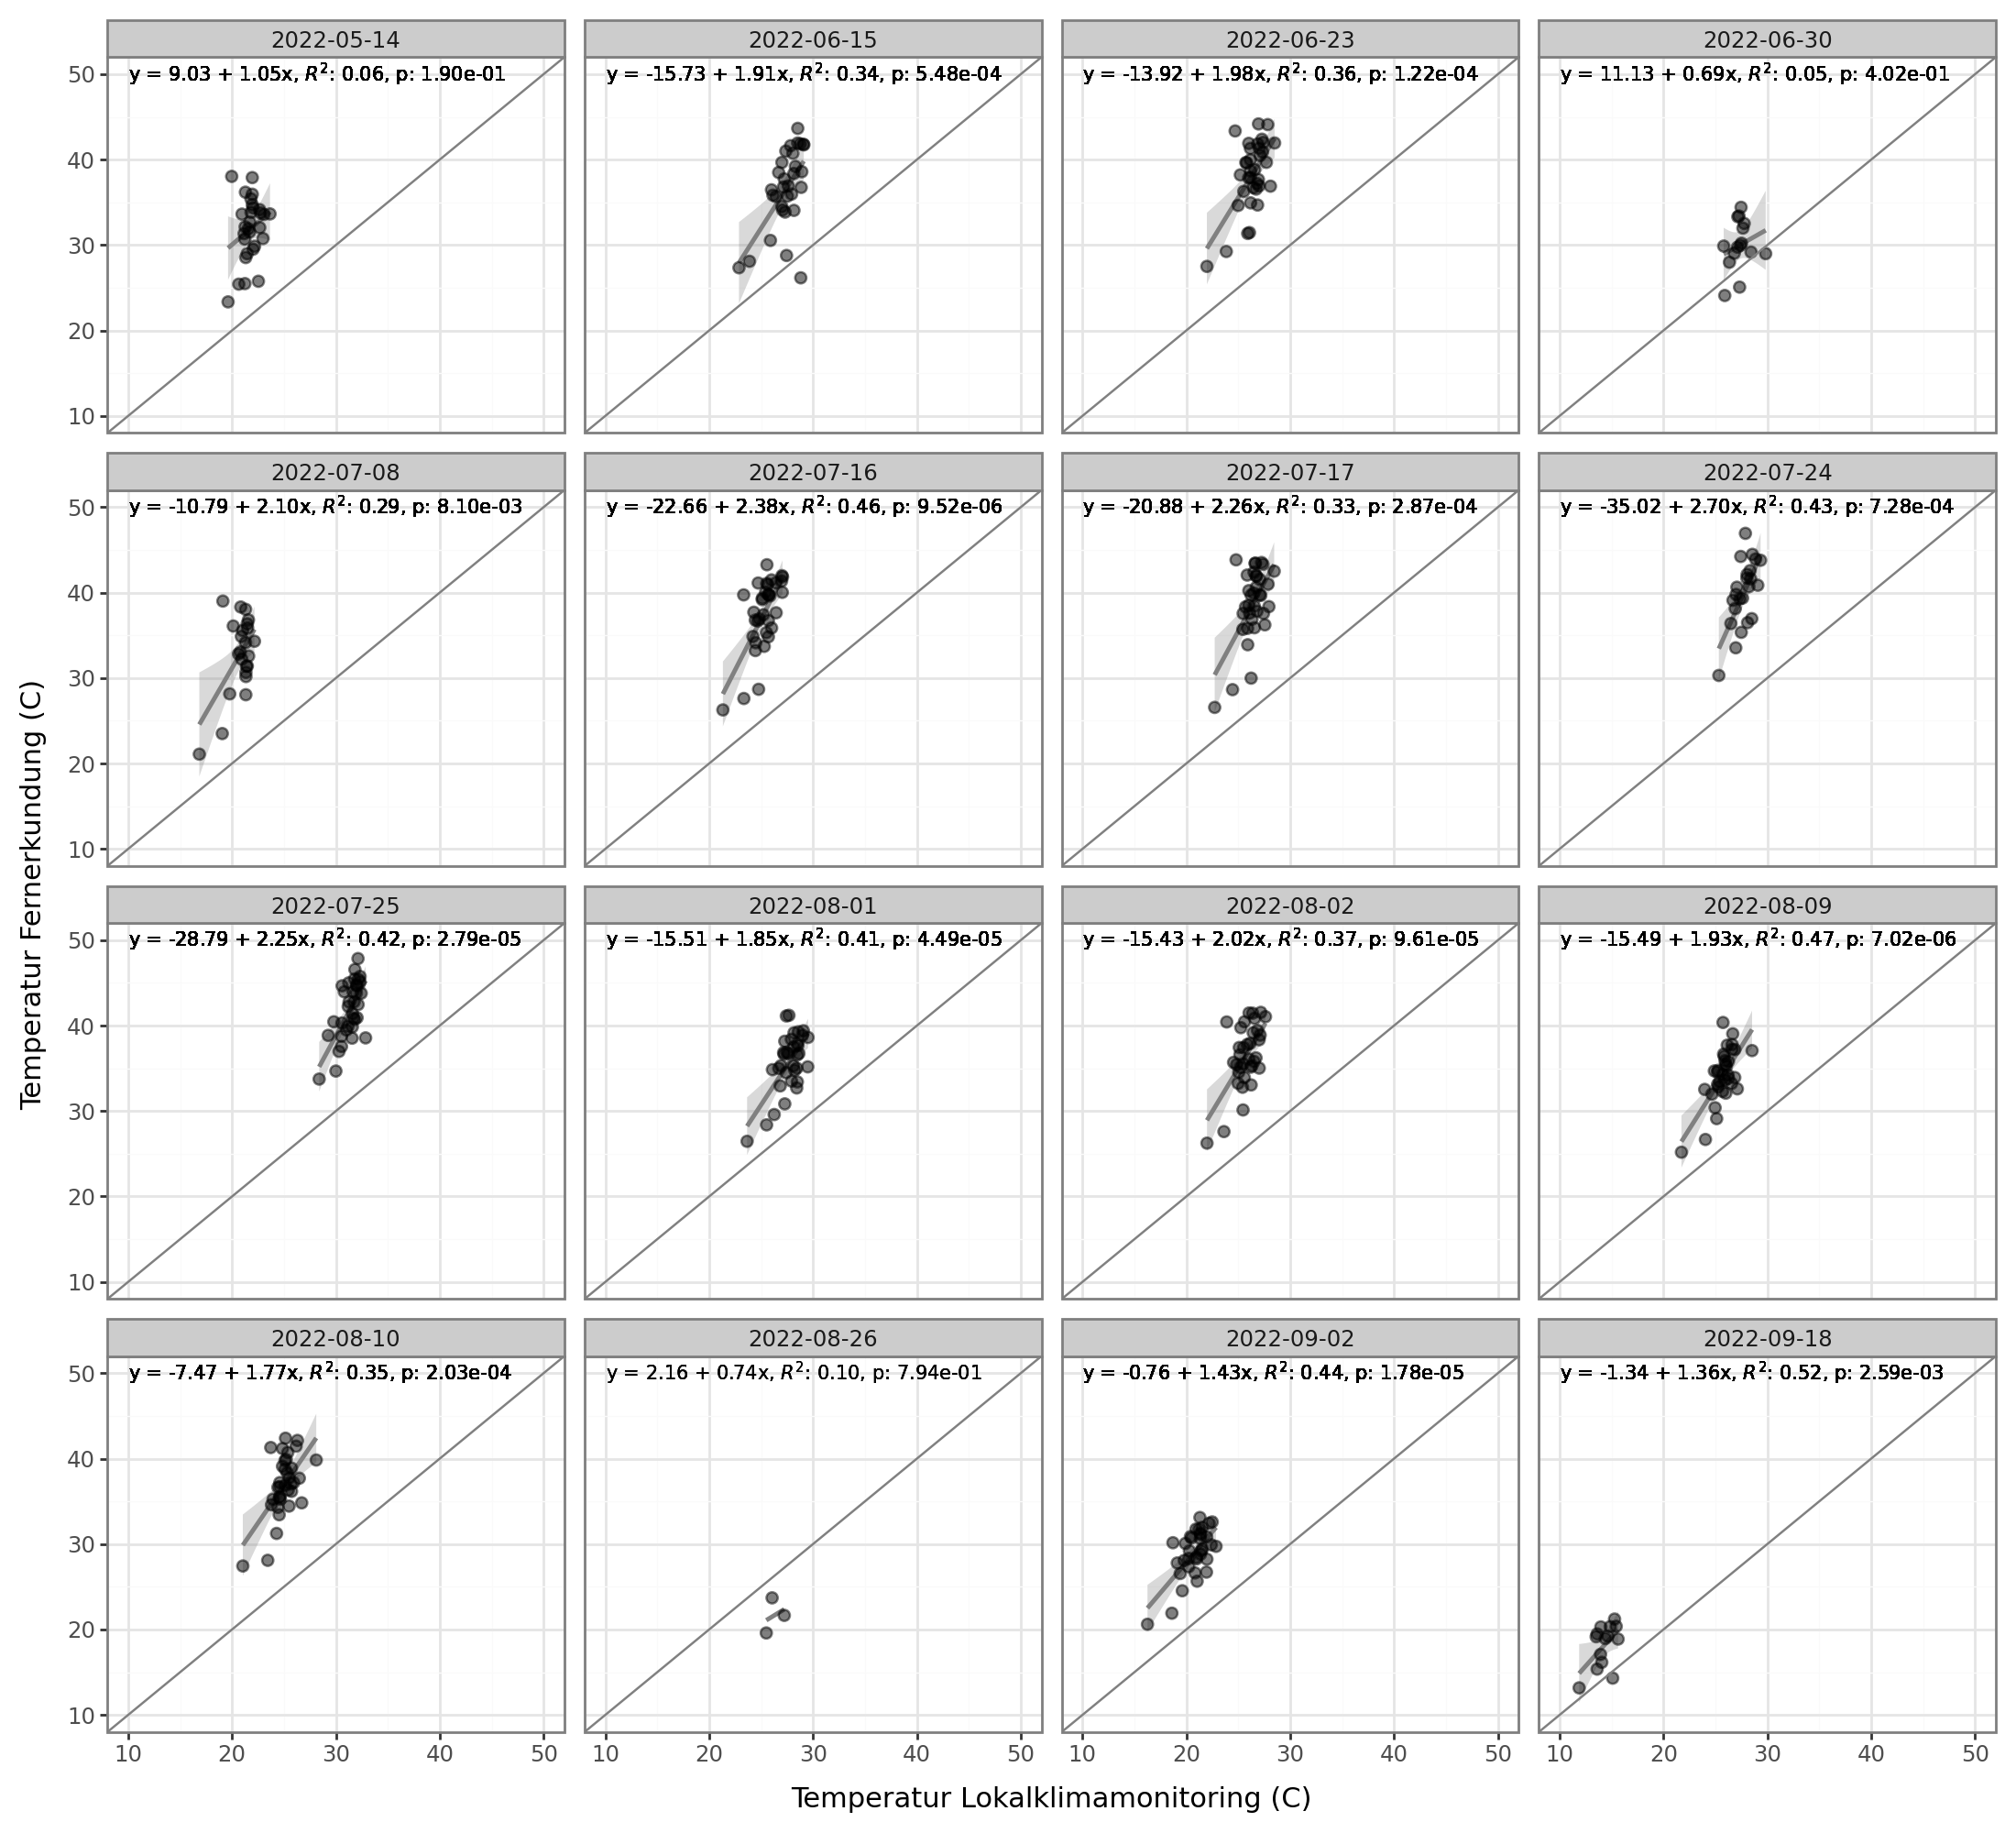

In [156]:
# Create the plot
gp = (
    ggplot(sensorSubset_merged)
    + aes(x="temperature", y="satelliteTemp", label='equation')
    + geom_smooth(method='lm', se=True, color='grey', fill='grey', alpha=0.3)
    + geom_point(alpha=0.5, size=2)
    + theme_bw()
    + theme(figure_size=(11, 10))
    + geom_abline(intercept=0, slope=1, color='grey')
    + facet_wrap("strtime", ncol=4)
    + xlim(10, 50)
    + ylim(10, 50)
    + labs(
        x="Temperatur Lokalklimamonitoring (C)",
        y="Temperatur Fernerkundung (C)"  
    )
    + geom_text(
        x=10,
        y=50,
        size=7.5,
        color="black",
        ha='left'
    )
)

gp

In [157]:
gp.save('by-date.pdf')

/Users/barbara/opt/anaconda3/envs/310gis/lib/python3.10/site-packages/plotnine/ggplot.py:604: PlotnineWarning: Saving 11 x 10 in image.
/Users/barbara/opt/anaconda3/envs/310gis/lib/python3.10/site-packages/plotnine/ggplot.py:605: PlotnineWarning: Filename: by-date.pdf
/Users/barbara/opt/anaconda3/envs/310gis/lib/python3.10/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 1 rows containing missing values.


/Users/barbara/opt/anaconda3/envs/310gis/lib/python3.10/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 1 rows containing missing values.


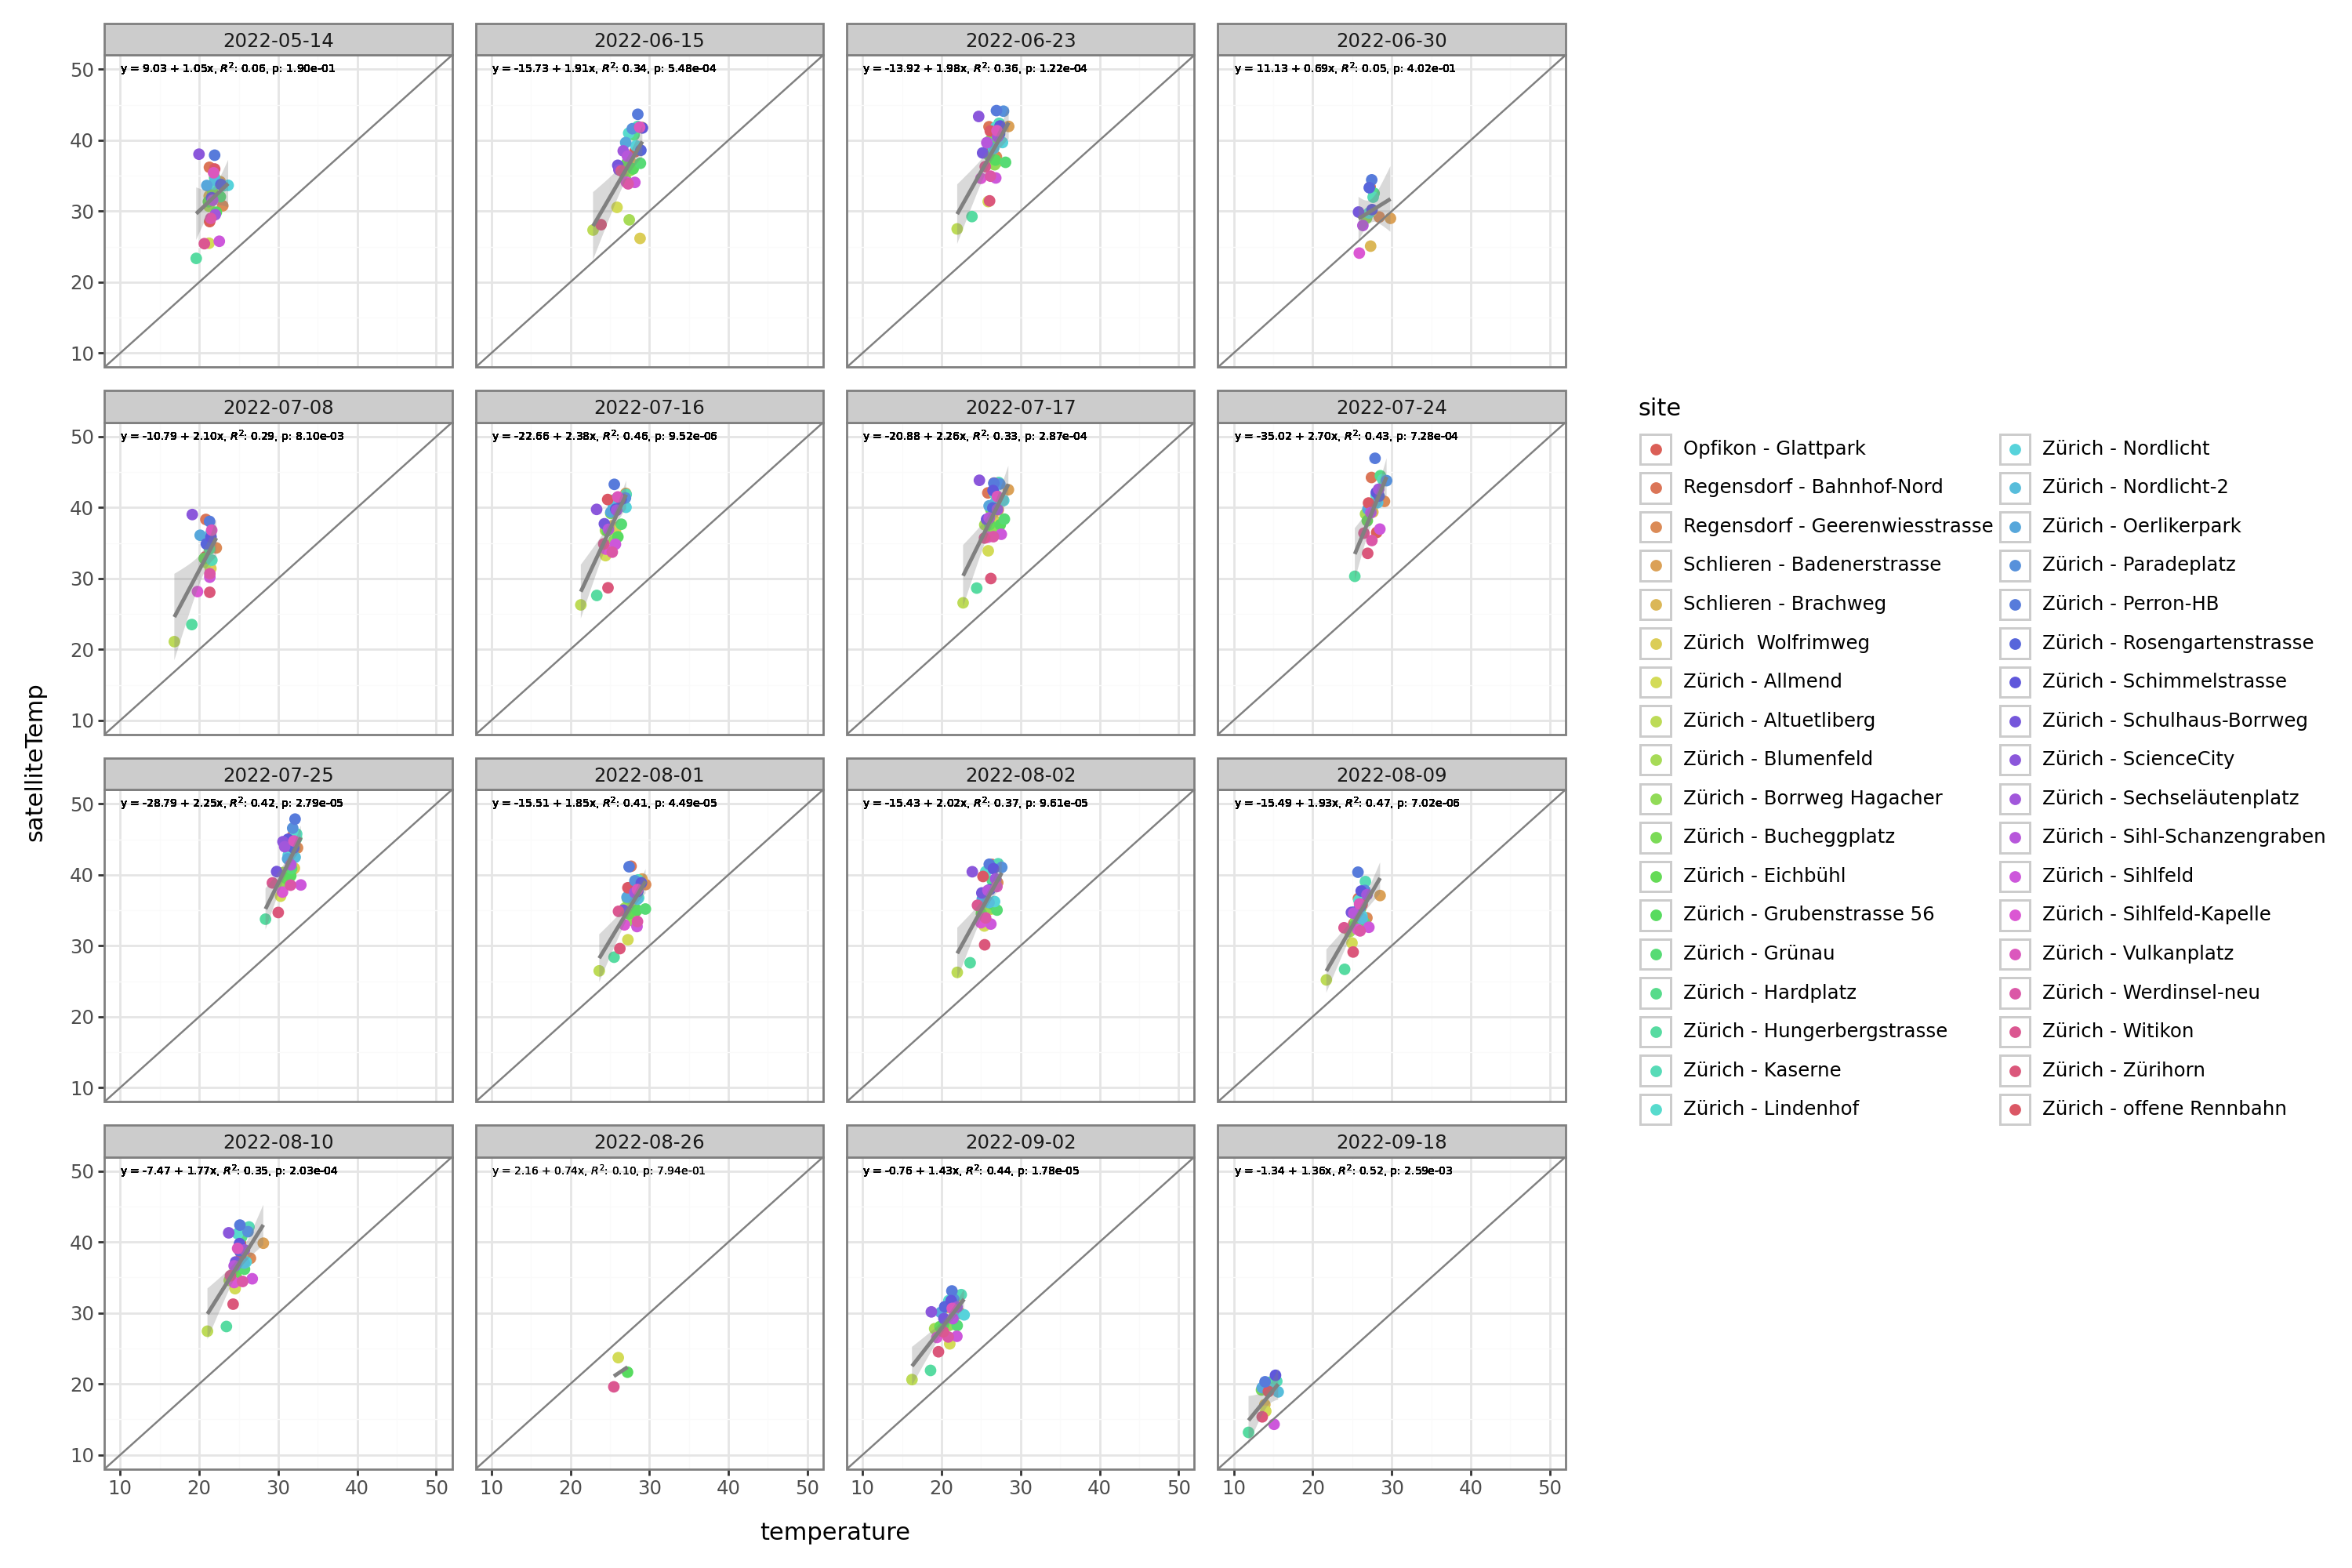

In [125]:
# Create the plot
gp = (
    ggplot(sensorSubset_merged)
    + aes(x="temperature", y="satelliteTemp", color='site', label='equation')
    + geom_point(alpha=1, size=2)
    + geom_smooth(method='lm', se=True, color='grey', fill='grey', alpha=0.3)
    + theme_bw()
    + theme(figure_size=(15, 10))
    + geom_abline(intercept=0, slope=1, color='grey')
    + facet_wrap("strtime", ncol=4)
    + xlim(10, 50)
    + ylim(10, 50)
    + geom_text(
        x=10,
        y=50,
        size=5,
        color="black",
        ha='left'
    )
)

gp

## Discussion

--> Satellite temperature is higher.

--> Good correlation within site. Not so good correlation within scene?

--> For measurements taken on different days at the same site there is a correlation, but not really for measurements taken on the same day but in different locations. That would suggest that the temperature differences can generally be measured well between days, but aren't as good at reflecting temperature at different sites on the same day. This would argue for averaging measurements from different days.

--> Based on cloud cover and temperature, use the following satellite images for further processing: `20220623`, `20220716`, `20220717`, `20220725`, `20220801`, `20220802`, `20220809`, `20220810`.

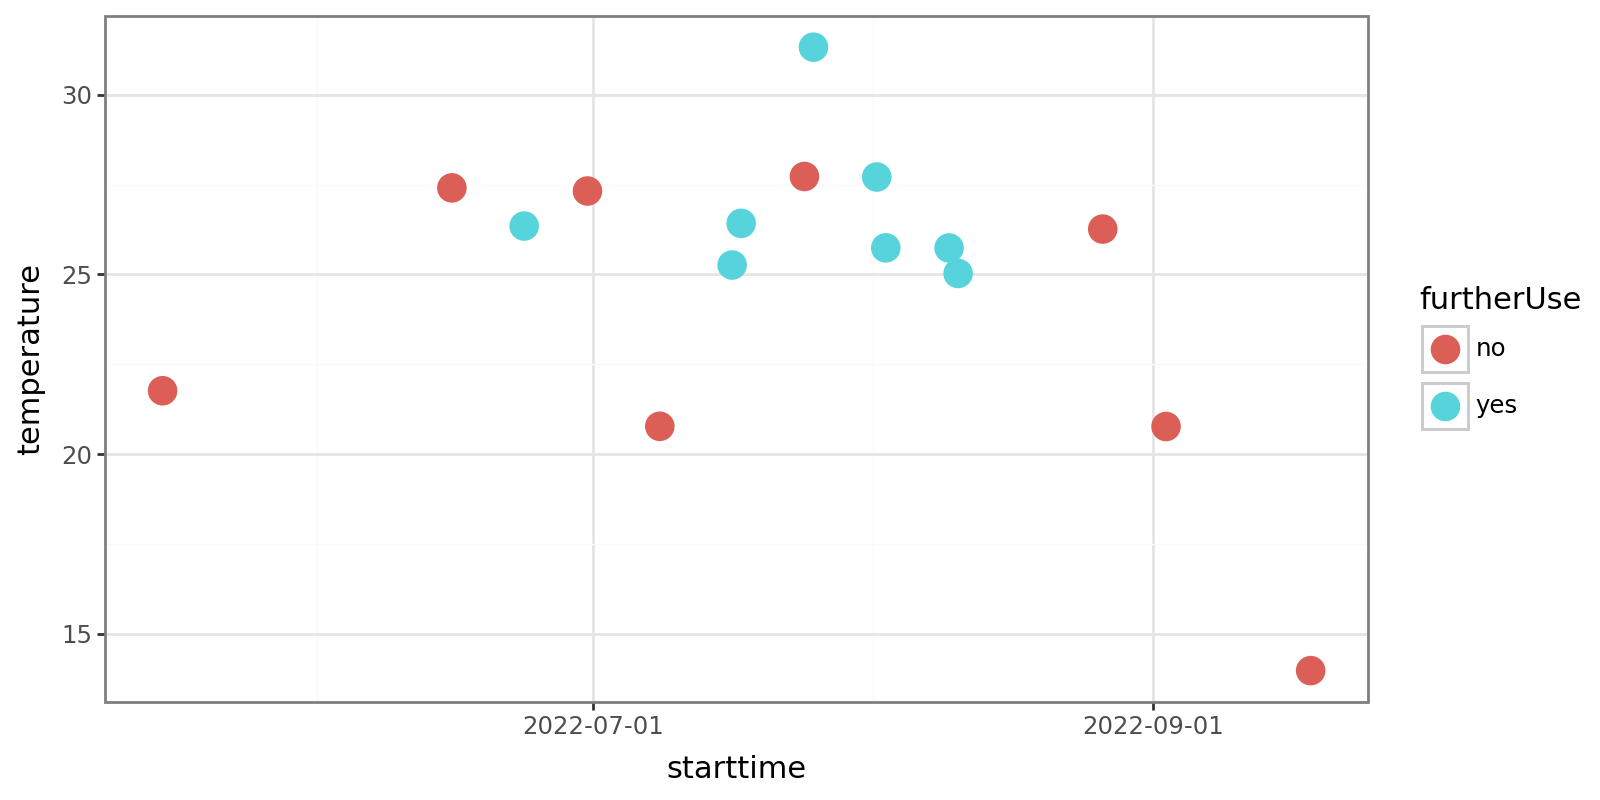

In [78]:
gp = (
    ggplot(averages)
    + aes(x="starttime", y="temperature", color='furtherUse')
    + geom_point(size=5)
    + theme_bw()
    + theme(figure_size=(8, 4))
)

gp

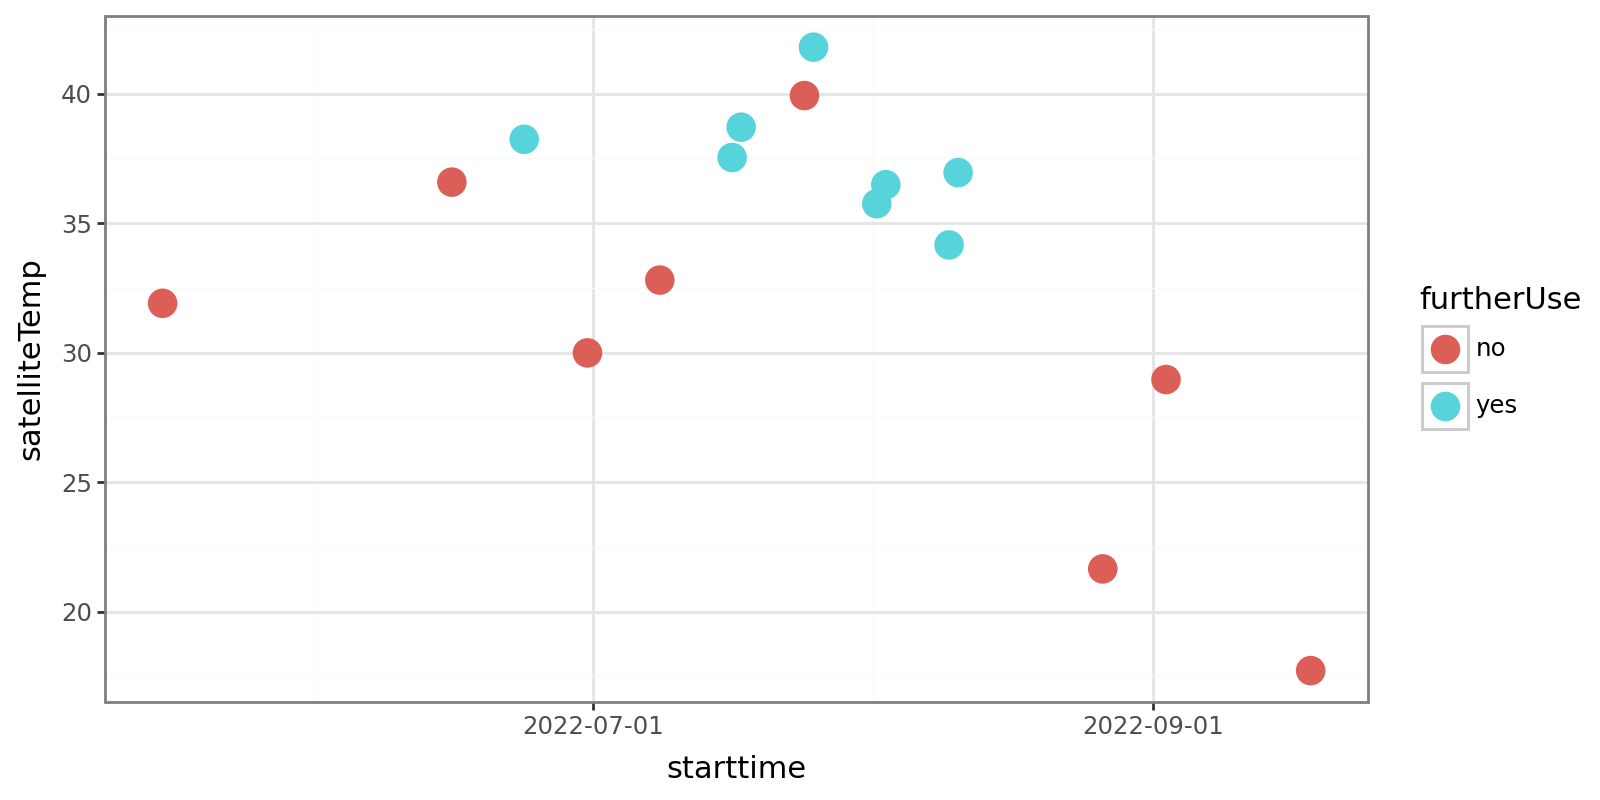

In [80]:
gp = (
    ggplot(averages)
    + aes(x="starttime", y="satelliteTemp", color='furtherUse')
    + geom_point(size=5)
    + theme_bw()
    + theme(figure_size=(8, 4))
)

gp

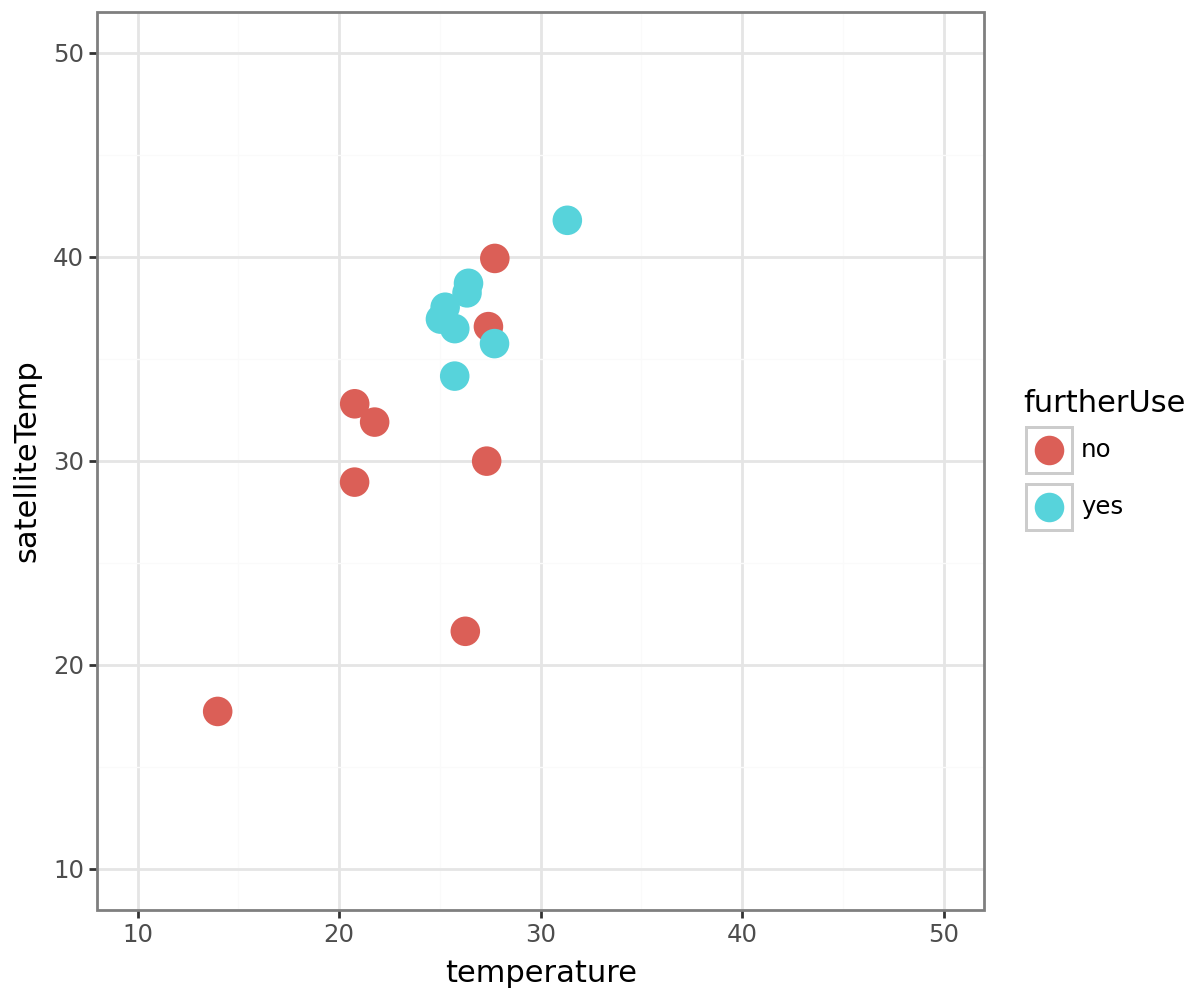

In [45]:
gp = (
    ggplot(averages)
    + aes(x="temperature", y="satelliteTemp", color='furtherUse')
    + geom_point(size=5)
    + theme_bw()
    + theme(figure_size=(6, 5))
    + xlim(10, 50)
    + ylim(10, 50)
)

gp

### Hitzetage max >30C

In [254]:
sensorSubsetDays = sensors.loc[~(sensors['site'].isin(sensorsToDrop))]

In [258]:
sensorSubsetDays['strtime'] = sensorSubsetDays['starttime'].apply(lambda row: datetime.strftime(row, '%Y-%m-%d'))

/var/folders/z3/x6qjmllx6314vnr7cktm58680000gn/T/ipykernel_5444/4186977111.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [259]:
averagesDays = sensorSubsetDays.groupby('strtime')[['temperature']].max().reset_index()

In [261]:
averagesDays['starttime'] = pd.to_datetime(averagesDays['strtime'], format='%Y-%m-%d')

In [269]:
heatdays = averagesDays.loc[averagesDays['temperature'] >= 30]

In [270]:
heatdays

strtime  temperature  starttime
14   2022-05-15        30.75 2022-05-15
17   2022-05-18        32.07 2022-05-18
18   2022-05-19        31.26 2022-05-19
19   2022-05-20        33.68 2022-05-20
34   2022-06-04        31.46 2022-06-04
41   2022-06-11        30.42 2022-06-11
42   2022-06-12        33.74 2022-06-12
45   2022-06-15        33.93 2022-06-15
46   2022-06-16        33.08 2022-06-16
47   2022-06-17        33.49 2022-06-17
48   2022-06-18        37.48 2022-06-18
49   2022-06-19        37.39 2022-06-19
50   2022-06-20        34.02 2022-06-20
51   2022-06-21        33.35 2022-06-21
53   2022-06-23        32.29 2022-06-23
55   2022-06-25        30.12 2022-06-25
56   2022-06-26        32.54 2022-06-26
60   2022-06-30        30.34 2022-06-30
62   2022-07-02        30.63 2022-07-02
63   2022-07-03        33.00 2022-07-03
72   2022-07-12        30.68 2022-07-12
73   2022-07-13        33.99 2022-07-13
74   2022-07-14        35.87 2022-07-14
75   2022-07-15        31.54 2022-07-15
76   2022-07-16        31.90 2022-07-16
77   2022-07-17        32.33 2022-07-17
78   2022-07-18        36.15 2022-07-18
79   2022-07-19        38.73 2022-07-19
80   2022-07-20        35.79 2022-07-20
81   2022-07-21        32.64 2022-07-21
82   2022-07-22        35.38 2022-07-22
84   2022-07-24        35.10 2022-07-24
85   2022-07-25        36.77 2022-07-25
88   2022-07-28        32.01 2022-07-28
91   2022-07-31        31.40 2022-07-31
92   2022-08-01        33.51 2022-08-01
93   2022-08-02        32.60 2022-08-02
94   2022-08-03        36.70 2022-08-03
95   2022-08-04        38.69 2022-08-04
96   2022-08-05        35.87 2022-08-05
99   2022-08-08        30.10 2022-08-08
100  2022-08-09        31.23 2022-08-09
101  2022-08-10        31.02 2022-08-10
102  2022-08-11        31.90 2022-08-11
103  2022-08-12        30.07 2022-08-12
104  2022-08-13        31.61 2022-08-13
107  2022-08-16        33.24 2022-08-16
108  2022-08-17        32.09 2022-08-17
115  2022-08-24        30.83 2022-08-24
116  2022-08-25        35.58 2022-08-25
117  2022-08-26        31.76 2022-08-26
119  2022-08-28        30.80 2022-08-28
120  2022-08-29        30.08 2022-08-29
121  2022-08-30        30.82 2022-08-30
127  2022-09-05        30.71 2022-09-05

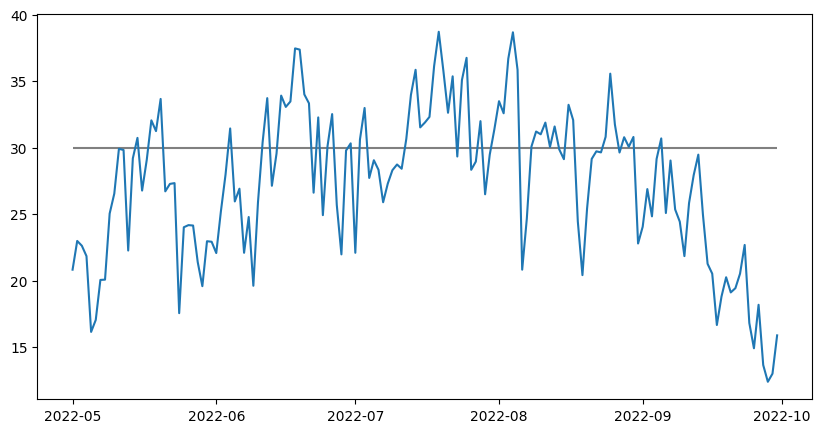

In [268]:
fig, ax = plt.subplots(figsize = (10, 5))

ax.hlines(30, min(averagesDays['starttime']), max(averagesDays['starttime']), color='grey')
ax.plot(averagesDays['starttime'], averagesDays['temperature'])

--> excluding satellite data based on hotter days doesn't make sense, because it was always hot.

## Plots only for selected days

In [61]:
selectedDays = ['2022-06-23', '2022-07-16', '2022-07-17', '2022-07-25', '2022-08-01', '2022-08-02', '2022-08-09', '2022-08-10']
sensorSubsetSelected = sensorSubset.loc[sensorSubset.strtime.isin(selectedDays)]

In [62]:
sensorSubsetSelected

starttime                            site  masl  magl  \
23374  2022-06-23 10:10:00             Opfikon - Glattpark   426   2.0   
27550  2022-06-23 10:10:00       Regensdorf - Bahnhof-Nord   440   2.0   
31736  2022-06-23 10:10:00  Regensdorf - Geerenwiesstrasse   439   2.0   
35964  2022-06-23 10:10:00      Schlieren - Badenerstrasse   394   2.0   
40245  2022-06-23 10:10:00            Schlieren - Brachweg   391   2.0   
...                    ...                             ...   ...   ...   
163621 2022-08-10 10:10:00                Zürich - Witikon   604   2.0   
165878 2022-08-01 10:10:00               Zürich - Zürihorn   408   2.0   
166021 2022-08-02 10:10:00               Zürich - Zürihorn   408   2.0   
167014 2022-08-09 10:10:00               Zürich - Zürihorn   408   2.0   
167155 2022-08-10 10:10:00               Zürich - Zürihorn   408   2.0   

              x        y  sensor  temperature  humidity  satelliteTemp  \
23374   2684807  1253174    2681        26.18     49.94      38.681055   
27550   2678019  1254725    2685        26.01     53.14      41.904248   
31736   2678262  1254941    2654        26.94     57.74      37.662485   
35964   2676170  1250196    2650        28.50     44.48      41.948682   
40245   2676474  1251042    2658        26.46     53.98      36.719111   
...         ...      ...     ...          ...       ...            ...   
163621  2687035  1245950    2653        23.95     48.74      35.245945   
165878  2684037  1245349    2679        26.26     54.49      29.592540   
166021  2684037  1245349    2679        25.46     60.71      30.129169   
167014  2684037  1245349    2679        25.12     47.73      29.114017   
167155  2684037  1245349    2679        24.29     47.54      31.243443   

           strtime  
23374   2022-06-23  
27550   2022-06-23  
31736   2022-06-23  
35964   2022-06-23  
40245   2022-06-23  
...            ...  
163621  2022-08-10  
165878  2022-08-01  
166021  2022-08-02  
167014  2022-08-09  
167155  2022-08-10  

[277 rows x 11 columns]

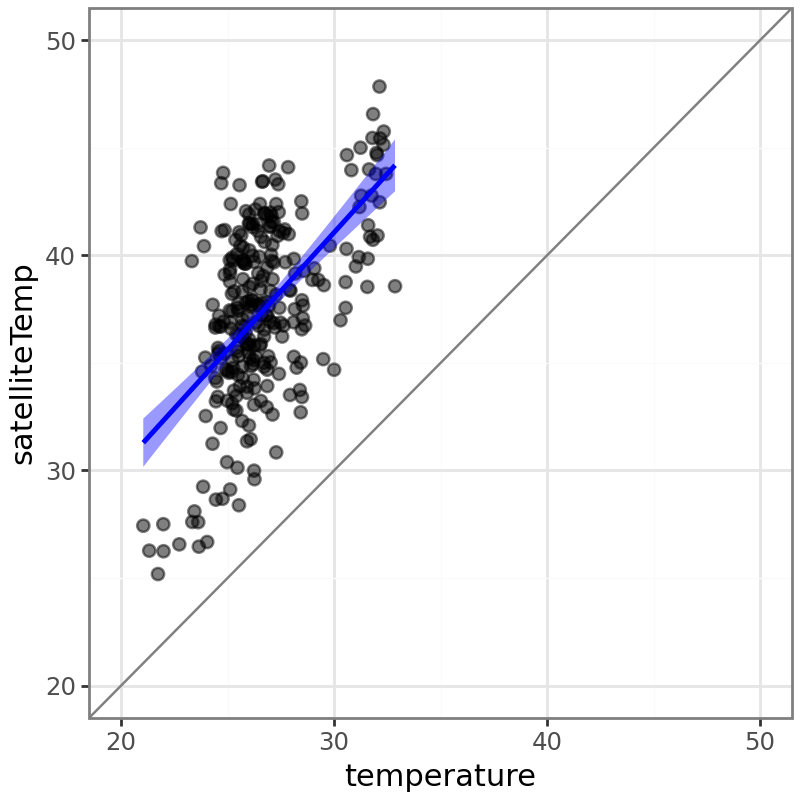

In [64]:
gp = (
    ggplot(sensorSubsetSelected)
    + aes(x="temperature", y="satelliteTemp")
    + geom_point(alpha=0.5, size=2)
    + theme_bw()
    + theme(figure_size=(4, 4))
    + geom_smooth(method = 'lm', se = True, color='blue', fill='blue')
    + geom_abline(intercept=0, slope=1, color='grey')
    + xlim(20, 50)
    + ylim(20, 50)
)

gp

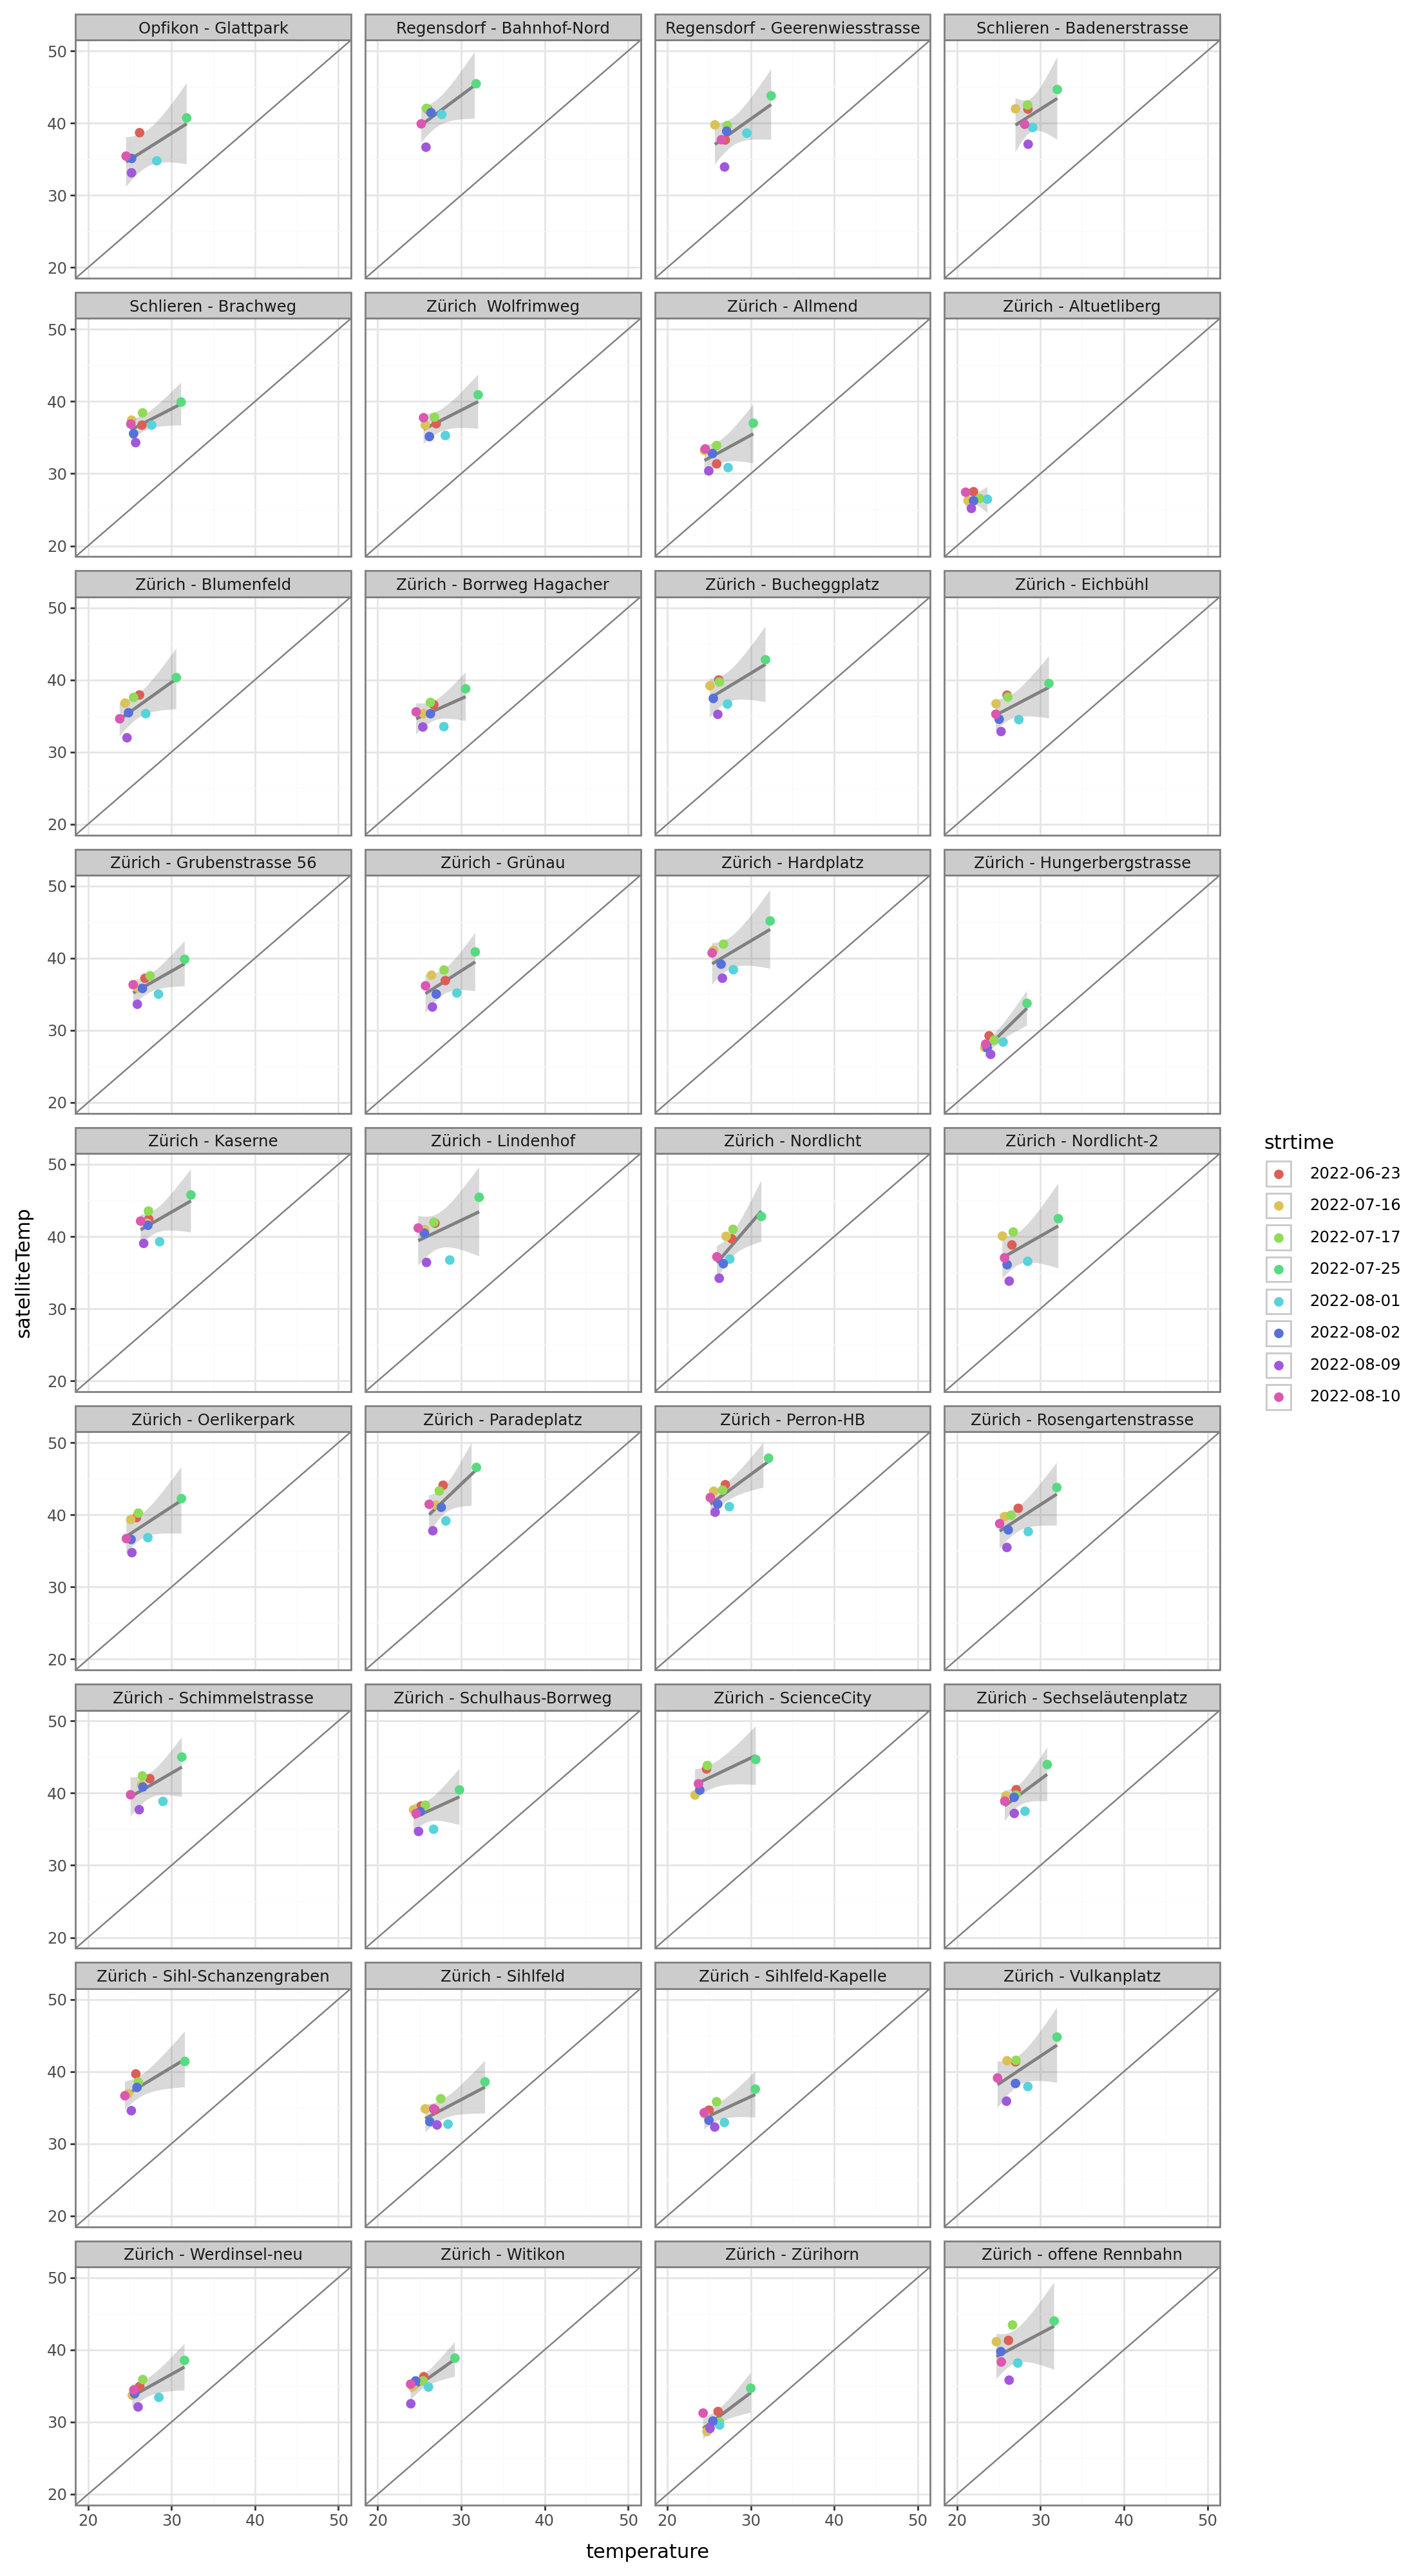

In [66]:
# Titers split and coloured by exposures
gp = (
    ggplot(sensorSubsetSelected)
    + aes(x="temperature", y="satelliteTemp", color='strtime')
    + geom_smooth(method = 'lm', se = True, color='grey', fill='grey', alpha=0.3)
    + geom_point(alpha=1, size=2)
    + theme_bw()
    + theme(figure_size=(11, 20))
    + geom_abline(intercept=0, slope=1, color='grey')
    + facet_wrap("site", ncol=4)
    + xlim(20, 50)
    + ylim(20, 50)
)

gp

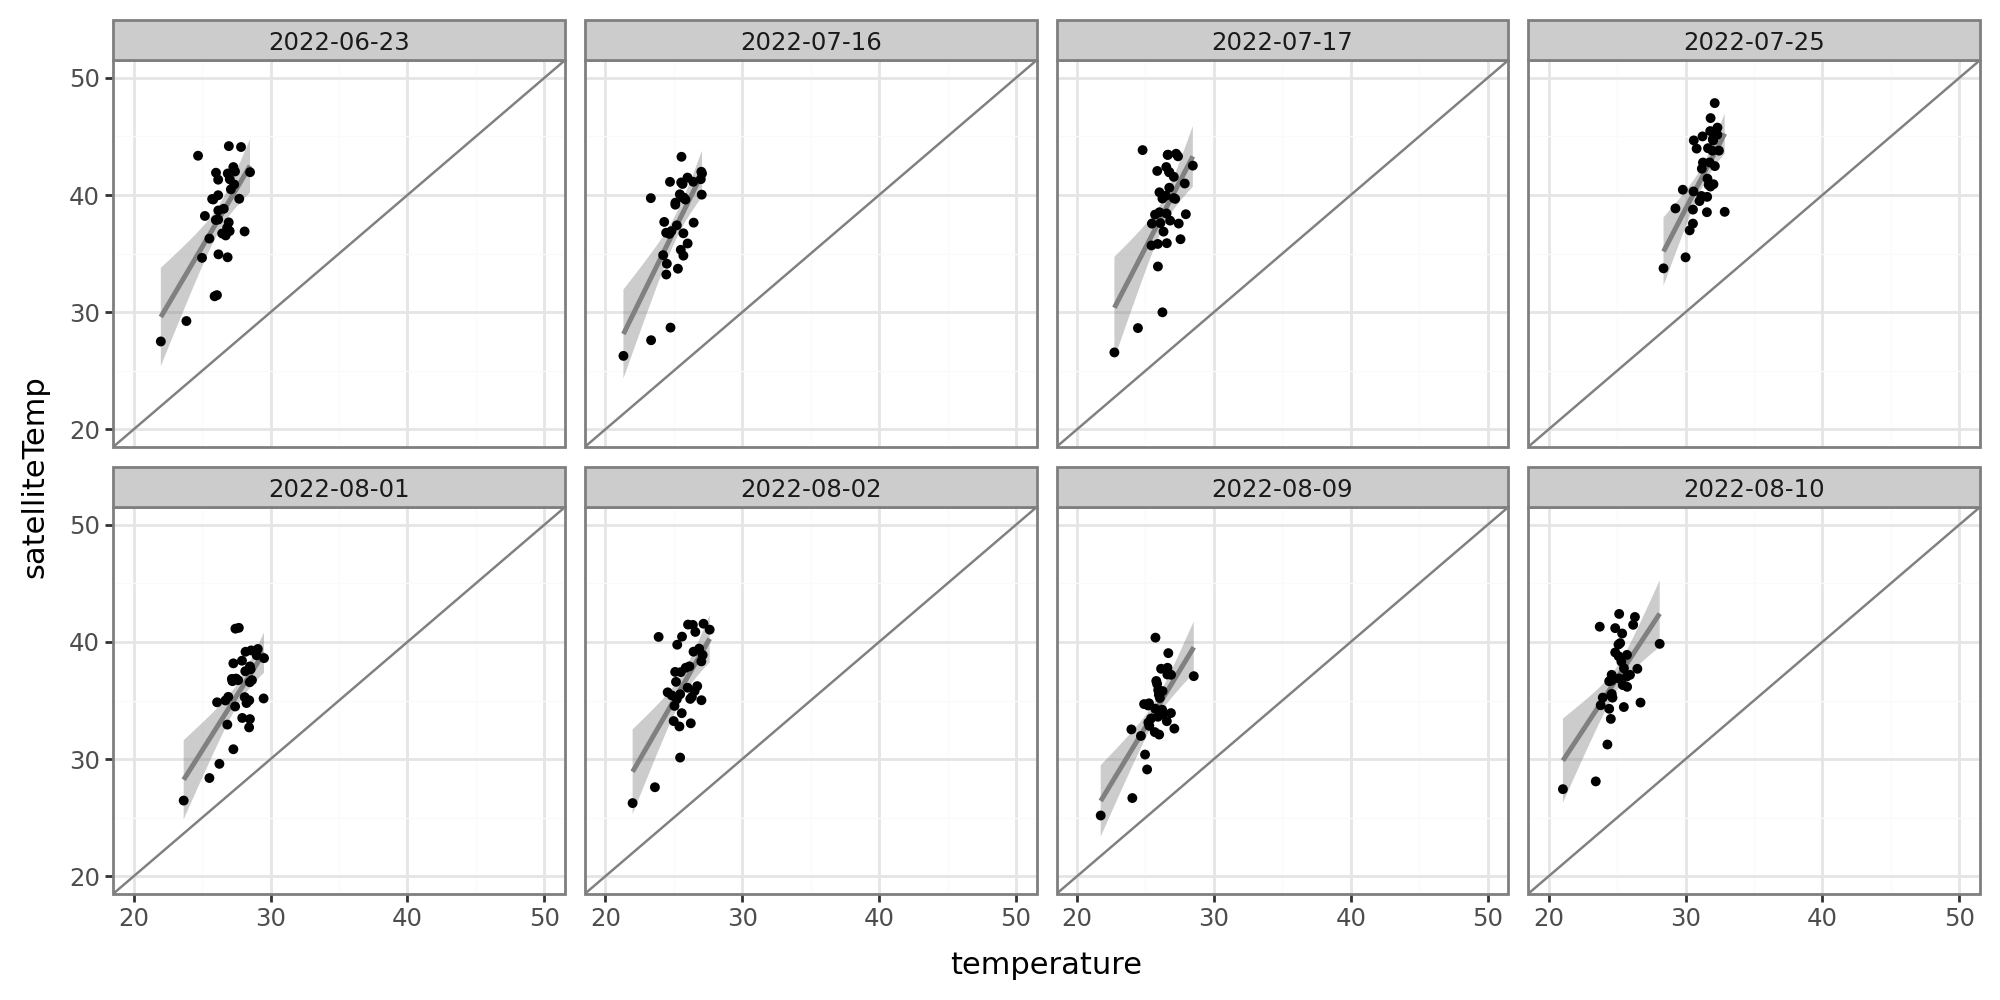

In [71]:
# Titers split and coloured by exposures
gp = (
    ggplot(sensorSubsetSelected)
    + aes(x="temperature", y="satelliteTemp")
    + geom_smooth(method = 'lm', se = True, color='grey', fill='grey')
    + geom_point(alpha=1, size=1)
    + theme_bw()
    + theme(figure_size=(10, 5))
    + geom_abline(intercept=0, slope=1, color='grey')
    + facet_wrap("strtime", ncol=4)
    + xlim(20, 50)
    + ylim(20, 50)
)

gp

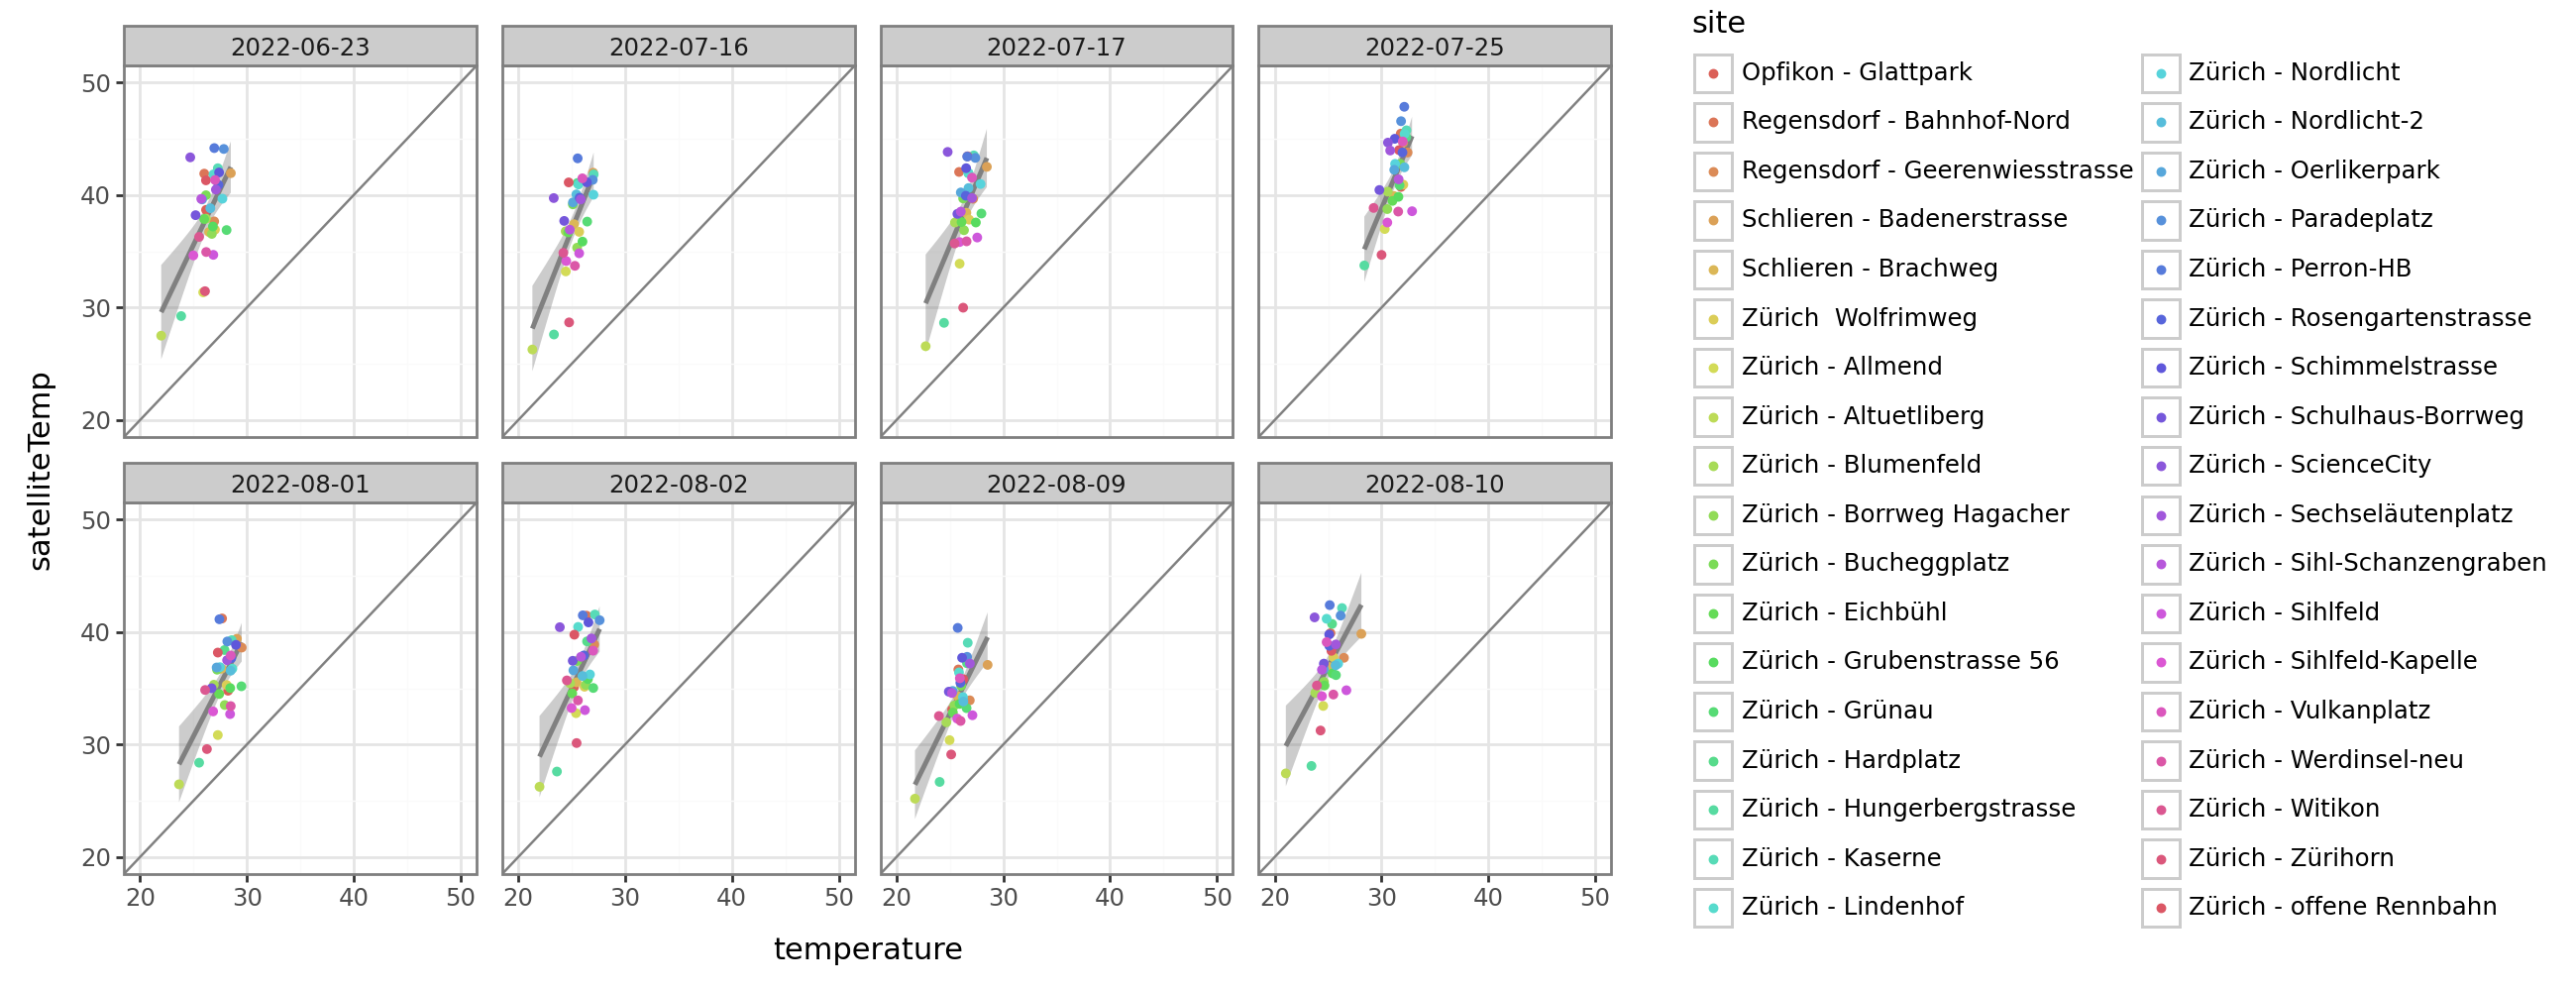

In [75]:
# Titers split and coloured by exposures
gp = (
    ggplot(sensorSubsetSelected)
    + aes(x="temperature", y="satelliteTemp", color="site")
    + geom_smooth(method = 'lm', se = True, color='grey', fill='grey')
    + geom_point(alpha=1, size=1)
    + theme_bw()
    + theme(figure_size=(13, 5))
    + geom_abline(intercept=0, slope=1, color='grey')
    + facet_wrap("strtime", ncol=4)
    + xlim(20, 50)
    + ylim(20, 50)
)

gp